In [2]:
import pandas as pd
import gzip
import json
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

In [3]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Beauty_5.json.gz')

In [4]:
df2 = getDF('meta_Beauty.json.gz')

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


In [5]:
df2.head()

,asin,description,title,imUrl,salesRank,categories,price,related,brand
0,0205616461,"As we age, our once youthful, healthy skin suc...",Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...,http://ecx.images-amazon.com/images/I/41DecrGO...,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturize...",NaN,NaN,NaN
1,0558925278,Mineral Powder Brush--Apply powder or mineral ...,Eco Friendly Ecotools Quality Natural Bamboo C...,http://ecx.images-amazon.com/images/I/51L%2BzY...,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes ...",NaN,NaN,NaN
2,0733001998,"From the Greek island of Chios, this Mastiha b...",Mastiha Body Lotion,http://ecx.images-amazon.com/images/I/311WK5y1...,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",NaN,NaN,NaN
3,0737104473,Limited edition Hello Kitty Lipstick featuring...,Hello Kitty Lustre Lipstick (See sellers comme...,http://ecx.images-amazon.com/images/I/31u6Hrzk...,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",NaN,NaN,NaN
4,0762451459,"The mermaid is an elusive (okay, mythical) cre...",Stephanie Johnson Mermaid Round Snap Mirror,http://ecx.images-amazon.com/images/I/41y2%2BF...,NaN,"[[Beauty, Tools & Accessories, Mirrors, Makeup...",19.98,NaN,NaN


In [6]:
df = df.drop(["reviewerName", "summary", "reviewTime"], axis=1, inplace=False)
df2 = df2.drop(["imUrl", "related", "brand"], axis=1, inplace = False)
new_df = df.merge(df2, how='inner', on='asin')
new_df['helpful_num'] = df['helpful'].apply(lambda x: x[0])
new_df['helpful_denom'] = df['helpful'].apply(lambda x: x[1])
new_df1 = new_df.drop("helpful", axis = 1)
new_df1.head()
count = new_df1.groupby("asin", as_index=False).count()

new_df2 = pd.merge(new_df1, count, how='right', on=['asin'])
new_df2.columns
new_df2["numberReview"] = new_df2["reviewerID_y"]
#Filter out products with review numbers >= 50
dfCount = new_df2[new_df2.numberReview >= 50]
dfCount

,reviewerID_x,asin,reviewText_x,overall_x,unixReviewTime_x,description_x,title_x,salesRank_x,categories_x,price_x,...,overall_y,unixReviewTime_y,description_y,title_y,salesRank_y,categories_y,price_y,helpful_num_y,helpful_denom_y,numberReview
105,AEEJGDRRGLBB1,B000050B6U,"I have long, thick, and straight hair. I bough...",2.0,1376438400,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
106,A2K6LI89NAD2J2,B000050B6U,I love that it has more heat settings than a l...,5.0,1365638400,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
107,A1P9UMP1XSE6MI,B000050B6U,I don't curl my hair every day so I didn't nee...,5.0,1391385600,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
108,A4WX0FZ1MMAUH,B000050B6U,I bought the biggest size of this curling just...,5.0,1395446400,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
109,AHP55PFHJL0H8,B000050B6U,It gets too hot and is hard to handle without ...,2.0,1391558400,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
110,ASPABROV8R7M5,B000050B6U,I like the size of the barrel on this iron and...,1.0,1380153600,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
111,A3T4OHEAHOJ700,B000050B6U,I didn't expect too much when I purchased this...,5.0,1395705600,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
112,AWR80FA3IQ633,B000050B6U,The 1/2&#34; barrel is perfect for styling sho...,5.0,1378684800,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
113,A3TQZLWYCQXLCQ,B000050B6U,This came quick and packaged just like I bough...,5.0,1355529600,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51
114,A2RUV6V9CWZAA0,B000050B6U,,3.0,1300838400,"Welcome to the world of advanced styling, wher...","Instant Heat Curling Iron, 1-Inch",{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,...,51,51,51,51,51,51,51,51,51,51


In [7]:
df_temp = dfCount[['reviewerID_x','asin','overall_x','salesRank_x','categories_x','price_x']]
df_temp.columns = ['reviewerID','asin','overall','salesRank','categories','price']

In [8]:
df_temp.head()

,reviewerID,asin,overall,salesRank,categories,price
105,AEEJGDRRGLBB1,B000050B6U,2.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95
106,A2K6LI89NAD2J2,B000050B6U,5.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95
107,A1P9UMP1XSE6MI,B000050B6U,5.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95
108,A4WX0FZ1MMAUH,B000050B6U,5.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95
109,AHP55PFHJL0H8,B000050B6U,2.0,{'Beauty': 3225},"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95


In [9]:
len(dfCount)

65823

In [10]:
df_temp = df_temp[pd.notnull(df_temp['salesRank'])]

In [11]:
len(df_temp)

64766

In [12]:
df_temp['salesRank'].value_counts().to_csv('rank value counts.csv')

extract rank information from salesRank 

In [13]:
sc = []
for i in range(len(list(df_temp['salesRank']))):
    v_out = list(df_temp['salesRank'])[i]
    sc.append(list(v_out.values())[0])

In [14]:
df_temp['rank'] = sc
df_temp1 = df_temp.drop('salesRank', axis=1, inplace=False)

In [15]:
n_users = df_temp1.reviewerID.unique().shape[0]
n_items = df_temp1.asin.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of items = ' + str(n_items))  

Number of users = 17552 | Number of items = 729


In [16]:
#Keep only userID, reviewerID, rating
#convert text to factors 
def minimal_and_factorize(df_original):

    df_minimal = df_original[['reviewerID','asin','overall']]
    labels_user, levels_user = pd.factorize(df_minimal['reviewerID'])
    df_minimal['userID'] = labels_user
    df_minimal = df_minimal.drop('reviewerID',axis = 1)
    labels_item, levels_item = pd.factorize(df_minimal['asin'])
    df_minimal['itemID'] = labels_item
    df_minimal = df_minimal.drop('asin',axis = 1)
    df_minimal['rating'] = df_minimal['overall'].astype(int)
    df_minimal = df_minimal.drop('overall',axis = 1)
        
    return df_minimal,(labels_user,levels_user),(labels_item,levels_item)

In [17]:
def factorize(df_original):
    df_minimal = df_original
    labels_user, levels_user = pd.factorize(df_minimal['reviewerID'])
    df_minimal['userID'] = labels_user
    df_minimal = df_minimal.drop('reviewerID',axis = 1)
    labels_item, levels_item = pd.factorize(df_minimal['asin'])
    df_minimal['itemID'] = labels_item
    df_minimal = df_minimal.drop('asin',axis = 1)
    
    
    df_minimal['rating'] = df_minimal['overall'].astype(int)
    df_minimal = df_minimal.drop('overall',axis = 1)
    df_minimal['rank'] = df_minimal['rank'].astype(int)
    
    #some of them don't have the fourth category in the list, so the catogiries will take the first element 
    df_minimal['categories'] = df_minimal['categories'].apply(lambda x: x[0])
    df_minimal['categories'] = df_minimal['categories'].apply(lambda x: x[3] if len(x) > 3 else x[0])
    labels_cat, levels_cat = pd.factorize(df_minimal['categories'])
    df_minimal['categories'] = labels_cat
    
    
    #price go into a few bins
    bins = [0, 10, 20, 30, 40, 50, 250]
    labels = [1,2,3,4,5,6]
    df_minimal['binned_price'] = pd.cut(df_minimal['price'], bins=bins, labels=labels)
    
    return df_minimal,(labels_user,levels_user),(labels_item,levels_item),(labels_cat,levels_cat)

In [67]:
df_temp1.head()

,reviewerID,asin,overall,categories,price,rank
105,AEEJGDRRGLBB1,B000050B6U,2.0,"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3225
106,A2K6LI89NAD2J2,B000050B6U,5.0,"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3225
107,A1P9UMP1XSE6MI,B000050B6U,5.0,"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3225
108,A4WX0FZ1MMAUH,B000050B6U,5.0,"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3225
109,AHP55PFHJL0H8,B000050B6U,2.0,"[[Beauty, Hair Care, Styling Tools, Irons, Cur...",13.95,3225


In [105]:
#df_temp1['rank'] = df_temp1['rank'].fillna(9999999)
train_orig,test_orig = train_test_split(df_temp1, test_size = 0.25)
train,label_level_u_train,label_level_i_train = minimal_and_factorize(train_orig)
test,label_level_u_test,label_level_i_test = minimal_and_factorize(test_orig)
train.head()

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,userID,itemID,rating
26810,0,0,4
132015,1,1,1
162723,2,2,3
122224,3,3,3
137272,4,4,4


In [19]:
train_orig.head()

,reviewerID,asin,overall,categories,price,rank
43502,A2CJXZZVTSYI9M,B00147FGJ8,5.0,"[[Beauty, Skin Care, Sun, Self-Tanners & Bronz...",12.79,636
61546,A2I417VXLSZCN1,B001MA0QY2,5.0,"[[Beauty, Hair Care, Styling Tools, Irons, Fla...",53.59,1
50374,A1BD342U8BF3UC,B001B7GJ2E,5.0,"[[Beauty, Tools & Accessories, Makeup Brushes ...",7.76,1681
101453,AF9YSNBUKREN6,B004675EI6,5.0,"[[Beauty, Makeup, Face, Foundation]]",1.99,14732
54420,A2GANR9I6XHTU9,B001ECQ5CA,5.0,"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",17.96,52457


In [20]:
#contains all item info
#used to create item-item similarity matrix
price_avg = np.mean(train_orig['price'])
train_orig['price'] = train_orig['price'].fillna(price_avg)
train_new,label_level_u_train,label_level_i_train,label_level_c_train = factorize(train_orig)
test_new,label_level_u_test,label_level_i_test,label_level_c_test = factorize(test_orig)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [21]:
train_new.head()

,categories,price,rank,userID,itemID,rating,binned_price
43502,0,12.79,636,0,0,5,2
61546,1,53.59,1,1,1,5,6
50374,2,7.76,1681,2,2,5,1
101453,3,1.99,14732,3,3,5,1
54420,4,17.96,52457,4,4,5,2


In [22]:
price_avg = np.mean(train_new['price'])
train_new['price'] = train_new['price'].fillna(price_avg)


(array([ 4757.,  5719.,  8524.,  6799.,  5494.,  3221.,  2785.,  2498.,
         1046.,  1375.,   938.,  1738.,   817.,   464.,   430.,   375.,
          220.,    79.,   103.,    91.,   314.,     0.,   325.,    79.,
           56.,     0.,     0.,     0.,     0.,    43.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,   128.,     0.,     0.,
            0.,    48.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,    71.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,    37.]),
 array([  6.00000000e-02,   2.45890000e+00,   4.85780000e+00,
          7.25670000e+00,   9.65

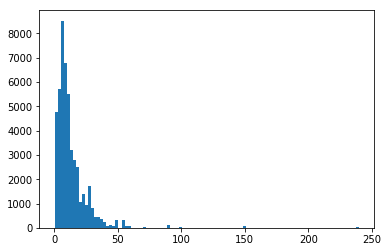

In [23]:
plt.hist(train_new['price'],bins = 100)

In [24]:
#item-item similarity matrix
#sim_item = cosine_similarity(train_new)

In [106]:
#train_dict: {user:{item,rating}}
train_dict = {}
for user in train.userID.unique():
    sub_dict = {}
    subset = train[train['userID'] == user]
    for item in subset.itemID:
        sub_dict[item] = list(subset[subset['itemID']==item].rating)[0]
    train_dict[user] = sub_dict

#test_dict: {(user,item):rating}   
test_dict = {}
for i in range(test.shape[0]):
    user = test.iloc[i].userID
    item = test.iloc[i].itemID
    test_dict[user,item] = test.iloc[i].rating

In [114]:
#before - train_dict: {user:{item,rating}}
#after - item_dict: {item:{user,rating}}
def transform_train_dict(dictionary):
    """
    This function transbose the user-item matrix pass into it to a item-user matrix
    """
    transform = {}
    for user, itemList in dictionary.items():
        print(user, itemList)
        for item, rating in itemList.items():
            if item not in transform.keys():
                transform[item] = {user : rating}
            else:    
                transform[item].update({user : rating})
    return transform

In [27]:
#create user-item matrix for train and test set
train_matrix = train.pivot(index='userID', columns='itemID', values='rating')
train_matrix = np.array(train_matrix.fillna(0))

test_matrix = test.pivot(index='userID', columns='itemID', values='rating')
test_matrix = np.array(test_matrix.fillna(0))

In [28]:
#compute cosine similarity between users and items
sim_user = cosine_similarity(train_matrix)

In [29]:
#user_pos dict: {userID: position in sim_user matrix}
#associate userID with position in similarity matrix
user_pos = {}
all_users = train.userID.unique()
for i in range(len(all_users)):
    curUserID = all_users[i]
    user_pos[curUserID] = i


In [90]:
#Find K nearest neighbors for user i
def find_neighbors(train,sim_matrix,user_i,k = 5):
    user_pos = {}
    all_users = train.userID.unique()
    for i in range(len(all_users)):
        curUserID = all_users[i]
        user_pos[curUserID] = i
    
    all_users = train.userID.unique()
    sim_for_user_i = [(user,sim_matrix[user_pos[user],user_pos[user_i]])
                     for user in all_users if user != user_i]
    sim_for_user_i.sort(key = lambda x: x[1],reverse = True)
    #return ID of users most similar to user_i
    return [x[0] for x in sim_for_user_i][:k]

In [31]:
#Calculate average rating in a dictionary 
def mean_rating(dictionary):
    total = sum([val for val in dictionary.values()])
    return (total.astype(float)) / len(dictionary)

In [97]:
#Rating Prediction function for user based
def user_based_predict(train,sim_user,test_dict,train_dict,k=5):
    prediction = {}
    train_dict_item = transform_train_dict(train_dict)

    for user_item in test_dict.keys():
        
        user,item = user_item
        
        #print (item)
        if user in train_dict.keys() and item in train_dict_item.keys():
            #print(user)
            average = mean_rating(train_dict[user])
            
            item_rating = train_dict[user]
            nn = find_neighbors(train,sim_user,user)
            mutual = list(set(nn) & set(list(train_dict_item[item].keys())))
            pred = sum([sim_user[user_pos[user],user_pos[cust]]*(train_dict_item[item][cust]-mean_rating(train_dict[cust]))
                        for cust in mutual])    
            prediction[user_item] = pred + average
    return prediction

In [65]:
#RMSE for dictionary
#Here prediction is a dictionary of the form {(user,item),rating}
def RMSE_dict(prediction,test_dict):
    error = 0
    for key in prediction.keys():
        error += (prediction[key]-test_dict[key])**2
    return np.sqrt(error/len(prediction.keys()))

In [66]:
#RMSE for matrix
#Here prediction is a user-item matrix for train
#test_matrix is user-item matrix for test
def rmse_matrix(prediction, test_matrix):
    prediction = prediction[test_matrix.nonzero()].flatten() 
    test_matrix = test_matrix[test_matrix.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, test_matrix))

In [98]:
predict_dict = user_based_predict(train,sim_user,test_dict,train_dict,k=5)

In [99]:
rmse_user = RMSE_dict(predict_dict,test_dict)
rmse_user

1.4148556283485128

### SGD Matrix Factorization

In [36]:
def MF_SGD(data, factors=30, maxIter=100, lr=0.02, conv=1e-4, lamda = 0.1):
    latent_mat_user = np.random.rand(n_users, factors) / 3
    latent_mat_item = np.random.rand(n_items, factors) / 3
    loss_list = []
    iteration = 0
    hist_loss = 0
    while iteration<maxIter:
        #print(iteration)
        loss = 0
        for i in range(data.shape[0]):
            uid, iid, rate = data.iloc[i]
            error = rate - np.dot(latent_mat_user[uid], latent_mat_item[iid])
            loss += error**2 + lamda*(np.linalg.norm(latent_mat_user[uid])+np.linalg.norm(latent_mat_item[iid]))
            old_user = latent_mat_user[uid]
            old_item = latent_mat_item[iid]
            latent_mat_user[uid] += lr*(error*latent_mat_item[iid]-lamda*old_user)
            latent_mat_item[iid] += lr*(error*latent_mat_user[uid]-lamda*old_item)
        iteration+=1
        loss_list.append(loss)
        diff = hist_loss-loss
        #to converge
        if abs(hist_loss) > abs(loss):
            lr *= 1.05
        else:
            lr *= 0.5
        if abs(diff) < abs(conv):
            break
        hist_loss = loss
    return np.dot(latent_mat_user, latent_mat_item.T),loss_list

In [40]:
def MF_SGD_single(data, factors=150, maxIter=10000000, lr=0.01, conv=1e-20, lamda = 0.01):
    latent_mat_user = np.random.rand(n_users, factors) / 3
    latent_mat_item = np.random.rand(n_items, factors) / 3
    loss_list = []
    iteration = 0
    hist_loss = 0
    
    
    while iteration<maxIter:
        loss = 0
        index = np.random.randint(len(data))
        
        uid, iid, rate = data.iloc[index]
        error = rate - np.dot(latent_mat_user[uid], latent_mat_item[iid])
        loss += error**2 + lamda*(np.linalg.norm(latent_mat_user[uid])+np.linalg.norm(latent_mat_item[iid]))
        old_user = latent_mat_user[uid]
        old_item = latent_mat_item[iid]
        latent_mat_user[uid] += lr*(error*latent_mat_item[iid]-lamda*old_user)
        latent_mat_item[iid] += lr*(error*latent_mat_user[uid]-lamda*old_item)
        iteration+=1
        loss_list.append(loss)
        diff = hist_loss-loss
        #to converge
        if abs(hist_loss) > abs(loss):
            lr *= 1.05
        else:
            lr *= 0.5
        if abs(diff) < abs(conv):
            break
        hist_loss = loss
    return np.dot(latent_mat_user, latent_mat_item.T),loss_list

In [ ]:
def MF_SGD_mini(data, factors=1000, maxIter=10000000, lr=0.001, conv=1e-8, lamda = 0.01):
    latent_mat_user = np.random.rand(n_users, factors) / 3
    latent_mat_item = np.random.rand(n_items, factors) / 3
    loss_list = []
    iteration = 0
    hist_loss = 0
    
    
    while iteration<maxIter:
       
        #if iteration%10000 == 0:
            #print(iteration)
            
        loss = 0
        indices = np.random.choice(len(data),32, replace=False)
        for i in indices:
            uid, iid, rate = data.iloc[i]
            error = rate - np.dot(latent_mat_user[uid], latent_mat_item[iid])
            loss += error**2 + lamda*(np.linalg.norm(latent_mat_user[uid])+np.linalg.norm(latent_mat_item[iid]))
            old_user = latent_mat_user[uid]
            old_item = latent_mat_item[iid]
            latent_mat_user[uid] += lr*(error*latent_mat_item[iid]-lamda*old_user)
            latent_mat_item[iid] += lr*(error*latent_mat_user[uid]-lamda*old_item)
        iteration+=1
        loss_list.append(loss)
        diff = hist_loss-loss
        #to converge
        if abs(hist_loss) > abs(loss):
            lr *= 1.05
        else:
            lr *= 0.5
        if abs(diff) < abs(conv):
            break
        hist_loss = loss
    print('done')    
    return np.dot(latent_mat_user, latent_mat_item.T),loss_list

In [41]:
sgd_result,lossList = MF_SGD_single(data = train, maxIter = 100)

In [42]:
rmse_matrix(sgd_result, test_matrix)

1.1522434216574788

In [37]:
rmse_svd = []
for k in range(3,15):
    u, s, vt = svds(train_matrix, k)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    rmse_svd.append(rmse_matrix(X_pred, test_matrix))

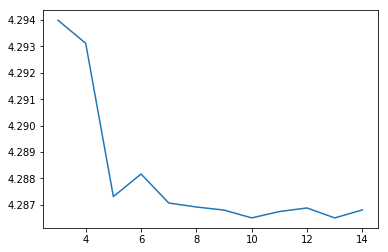

In [51]:
x = np.arange(3,15)
plt.plot(x,rmse_svd)

Rebuild item-item similarity matrix

In [ ]:
lrs = [0.001,0.005,0.01,0.025,0.05,0.1]
lamdas = [0.001,0.005,0.01,0.05,0.1,0.2]
factors = [150, 151, 152, 153, 154]
loss_sgd = {}
for lr in lrs:
    for lm in lamdas:
        for f in factors:
            sgd_result,lossList =  MF_SGD(data = train, factors = f, maxIter = 300, lr=lr, conv=1e-4, lamda = lm)
            label = (f, lm, lr)
            loss_sgd[label] = sgd_result

In [49]:
def find_neighbors_item(train,sim_matrix,item_i,k = 5):
    all_items = train.itemID.unique()
    sim_for_item_i = [(item,sim_matrix[item,item_i]) for item in all_items if item != item_i]
    sim_for_item_i.sort(key = lambda x: x[1],reverse = True)
    #return ID of items most similar to item_i
    return [x[0] for x in sim_for_item_i][:k]

In [48]:
def item_based_predict(train,sim_item,train_dict, test_dict,k=5):
    prediction = {}
    train_dict_item = transform_train_dict(train_dict)
    for user, item in test_dict.keys():
        #train to get nearest neighbor
        if item in train_dict_item.keys():
            average = mean_rating(train_dict_item[item])
            nn = find_neighbors_item(train, sim_item, item, k)
            if user in train_dict.keys():
                mutual = list(set(nn) & set(list(train_dict[user].keys())))
                w_sim = [sim_item[item, i] for i in mutual]
                r_sim = [train_dict[user][i] for i in mutual]
                w_array = np.array(w_sim)
                r_array = np.array(r_sim)
                denom = sum(abs(w_array))
                numer = sum(w_array*r_array)
            if denom == 0:
                prediction[(user,item)]= average
            else:
                prediction[(user,item)]= numer/denom
    return prediction

In [ ]:
def item_based_predict2(train,sim_item,train_dict,k=5):
    prediction = {}
    train_dict_item = transform_train_dict(train_dict)
    for user in train_dict.keys():
        #train to get nearest neighbor
        itemset = train_dict[user] 
        
        for item in itemset:
            #if item in test_item.keys():
            nn = find_neighbors_item(train, sim_item, item, k)
            average = mean_rating(train_dict_item[item])
            mutual = list(set(nn) & set(list(train_dict[user].keys())))
            w_sim = [sim_item[item, i] for i in mutual]
            r_sim = [train_dict[user][i] for i in mutual]
            w_array = np.array(w_sim)
            r_array = np.array(r_sim)
            denom = sum(abs(w_array))
            numer = sum(w_array*r_array)
            if denom == 0:
                prediction[(user,item)]= average
            else:
                prediction[(user,item)]= numer/denom
    return prediction

In [117]:
class item_based_CF():
    
    def __init__(self, sim_item):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.sim_item = sim_item
        
      
   
    def fit(self, train, train_dict, k=3):
        '''
        Fit item based CF model
        '''
        
        self.average = {}
        self.numer = {}
        self.denom = {}
        
        train_dict_item = transform_train_dict(train_dict)
        for user in train_dict.keys():
            #train to get nearest neighbor
            itemset = train_dict[user] 

            for item in itemset.keys():
                #if item in test_item.keys():
                nn = find_neighbors_item(train, sim_item, item, k)
                self.average[item] = mean_rating(train_dict_item[item])
                mutual = list(set(nn) & set(list(train_dict[user].keys())))
                w_sim = [sim_item[item, i] for i in mutual]
                r_sim = [train_dict[user][i] for i in mutual]
                w_array = np.array(w_sim)
                r_array = np.array(r_sim)
                den = sum(abs(w_array))
                num = sum(w_array*r_array)
                self.numer[(user,item)] = num
                self.denom[(user,item)] = den
                
        self.fitted = True
                
        return self
    
    def predict_train(self, train_dict):
        prediction = {}
        for user in train_dict.keys():
            itemset = train_dict[user]
            for item in itemset.keys():
                numer = self.numer[(user,item)]
                denom = self.denom[(user,item)]
                
                if denom == 0:
                    prediction[(user,item)]= self.average[item]
                else:
                    prediction[(user,item)]= numer/denom
        return prediction
    
    def predict_test(self,train_dict,test_dict):
        prediction = {}
        
        numer = 0
        denom = 0
        
        for user_item in test_dict.keys():
            user,item = user_item
            
            if user in train_dict.keys():
                if item in train_dict[user].keys():
                    numer = self.numer[(user,item)]
                    denom = self.denom[(user,item)]
                    
            if denom == 0:
                prediction[(user,item)]= self.average[item]
            else:
                prediction[(user,item)]= numer/denom
        return prediction

In [120]:
item_based= item_based_CF(sim_item_new)
model = item_based.fit(train, train_dict)
y = model.predict_train(train_dict)

0 {0: 4, 136: 4, 557: 4, 194: 5, 501: 5, 124: 4, 598: 4, 174: 3, 263: 5, 154: 2, 205: 4}
1 {1: 1, 138: 3, 302: 5, 561: 4, 10: 2, 469: 4, 49: 2, 454: 3, 180: 5, 61: 4, 399: 4, 34: 1, 223: 4, 563: 5, 220: 4, 7: 5, 103: 4, 474: 2, 113: 4, 271: 4, 124: 4, 461: 4, 527: 5, 45: 4, 494: 4, 323: 5, 129: 3, 100: 3, 374: 3, 413: 4, 689: 4, 693: 3, 387: 3, 356: 5}
2 {2: 3}
3 {3: 3, 17: 4, 16: 2, 476: 4, 373: 4, 283: 5}
4 {4: 4, 648: 4}
5 {5: 4, 147: 5, 545: 5, 599: 5, 117: 4, 64: 5, 108: 5, 118: 5}
6 {6: 2, 510: 5, 367: 4, 90: 3, 336: 5}
7 {7: 4, 171: 3, 264: 2, 241: 4, 293: 4, 613: 5, 41: 5, 340: 4, 575: 4, 556: 4, 446: 4, 154: 2, 223: 4}
8 {8: 4, 430: 5, 538: 5, 494: 4, 323: 5, 525: 3, 478: 5, 101: 3}
9 {9: 5, 720: 5, 573: 5}
10 {10: 5}
11 {11: 5, 443: 1, 660: 4, 73: 5, 289: 4, 239: 3}
12 {12: 5, 593: 5, 316: 5, 495: 5}
13 {13: 4, 129: 5, 403: 4, 98: 5, 82: 4, 597: 5, 116: 3, 174: 4}
14 {14: 5, 311: 4, 306: 4}
15 {15: 5, 142: 5}
16 {16: 5}
17 {17: 5}
18 {18: 3}
19 {19: 3, 9: 4, 79: 5, 713: 4}
20

278 {100: 4, 601: 5, 469: 4, 179: 5, 130: 5, 153: 4, 233: 5, 560: 4, 568: 4}
279 {133: 1, 674: 1}
280 {229: 4, 551: 5, 630: 5}
281 {19: 1, 437: 5, 625: 1, 245: 1, 67: 1, 404: 4, 362: 5, 488: 1}
282 {133: 4, 547: 5, 354: 4}
283 {230: 4, 574: 5, 272: 5, 407: 5, 519: 5, 707: 3, 418: 5, 428: 5, 222: 5, 263: 4, 725: 3, 441: 5, 388: 5, 98: 4, 132: 4, 332: 5, 71: 5, 279: 5, 376: 5, 454: 5, 182: 5, 85: 3, 543: 5, 160: 4, 341: 5, 267: 5, 49: 5, 481: 5, 397: 5, 248: 5, 716: 5, 498: 5, 218: 5, 94: 5, 538: 5, 260: 5, 360: 4, 403: 4, 399: 5, 154: 4, 513: 1, 426: 5, 250: 5, 601: 4, 523: 5, 109: 5, 198: 3, 619: 5, 685: 5}
284 {231: 5, 355: 3}
285 {233: 3}
286 {159: 4, 153: 3, 154: 5, 242: 5, 130: 5, 312: 4}
287 {234: 5, 99: 5, 550: 5, 218: 5, 269: 5, 151: 5, 656: 5, 536: 5, 249: 5, 148: 5, 496: 5}
288 {147: 5, 258: 5, 254: 5, 257: 5}
289 {235: 5, 143: 4, 183: 5, 39: 4, 660: 4, 337: 3, 75: 5, 286: 5, 292: 4, 131: 5, 33: 5, 9: 4}
290 {236: 1, 197: 2, 573: 5}
291 {237: 4}
292 {74: 2, 245: 3, 58: 4, 109:

647 {416: 4, 360: 5, 328: 5}
648 {335: 3, 448: 3, 526: 4}
649 {417: 3}
650 {362: 5}
651 {411: 5, 406: 5, 512: 5, 321: 3, 561: 4, 170: 5, 698: 5, 71: 5}
652 {418: 3, 441: 3, 272: 5, 693: 1, 605: 4, 387: 3, 44: 2, 173: 5, 451: 5, 677: 4, 700: 3, 13: 4, 154: 1, 82: 3, 501: 5, 242: 5}
653 {419: 3, 135: 2, 653: 2, 304: 5}
654 {239: 2, 131: 3, 146: 4}
655 {60: 5, 484: 5, 28: 5}
656 {72: 2, 451: 5}
657 {420: 4, 145: 2, 700: 5, 706: 2, 454: 4, 511: 5, 84: 3}
658 {259: 3, 115: 2}
659 {139: 5}
660 {360: 5}
661 {31: 3, 435: 4, 536: 4, 361: 3, 269: 5, 191: 3}
662 {214: 5, 256: 5, 30: 3, 348: 5}
663 {299: 2, 338: 1, 256: 3, 313: 5, 548: 4, 125: 5, 357: 4}
664 {421: 4, 117: 3, 516: 4, 488: 5, 377: 3, 79: 4, 192: 5, 251: 2, 28: 5, 307: 4, 470: 4, 247: 5, 78: 5}
665 {422: 2, 132: 4, 211: 2, 426: 2, 209: 4, 383: 4, 397: 4, 187: 5, 658: 3, 129: 3, 344: 2, 102: 3, 363: 3}
666 {320: 5}
667 {423: 5, 510: 1}
668 {213: 1, 274: 5}
669 {356: 1, 209: 4, 132: 3, 58: 1, 427: 3, 220: 5, 393: 5, 486: 5, 542: 1, 168

1333 {208: 4}
1334 {47: 5, 359: 5, 338: 5}
1335 {8: 5, 461: 5, 589: 5, 350: 4, 538: 5, 291: 4, 88: 5, 486: 5, 528: 5, 664: 3, 393: 3, 182: 5, 658: 5, 727: 5, 689: 4}
1336 {401: 5, 369: 5, 209: 4, 584: 5, 1: 5, 583: 3, 293: 4, 58: 3, 519: 3, 243: 3, 397: 2, 527: 4, 76: 3, 233: 5, 716: 5}
1337 {592: 5, 93: 3}
1338 {7: 4, 635: 5, 571: 3, 662: 5, 418: 5, 233: 4, 168: 1, 591: 5, 334: 4, 506: 3, 501: 3, 268: 5}
1339 {532: 4, 11: 2}
1340 {5: 5, 547: 5, 258: 5}
1341 {340: 4, 241: 5, 10: 2, 685: 4}
1342 {91: 5, 127: 5}
1343 {551: 5, 630: 5}
1344 {13: 5, 478: 5, 225: 3, 474: 2, 34: 4, 180: 4, 372: 3}
1345 {292: 2, 146: 5, 713: 3, 120: 4, 576: 4, 307: 3}
1346 {196: 4, 486: 4, 527: 5, 401: 4, 160: 5, 363: 5, 280: 4, 332: 3, 205: 5, 182: 3, 513: 3, 240: 4, 494: 5, 82: 2, 629: 4, 225: 1, 34: 4, 525: 4, 580: 5}
1347 {175: 5}
1348 {208: 1, 10: 1, 647: 5, 510: 1}
1349 {0: 5}
1350 {280: 2, 96: 5, 222: 5, 263: 5, 271: 5}
1351 {603: 5, 597: 4, 58: 5, 707: 3, 371: 3, 702: 4, 228: 5, 84: 3, 455: 5}
1352 {45

1958 {327: 3, 130: 4, 603: 4, 187: 5, 485: 5}
1959 {481: 5, 477: 5, 507: 5, 276: 5, 550: 5, 282: 5, 234: 5, 166: 5, 99: 5}
1960 {19: 5}
1961 {265: 5, 643: 5, 709: 5, 84: 5}
1962 {9: 5, 39: 3, 253: 5, 79: 4, 720: 4, 239: 5, 162: 4}
1963 {19: 5, 497: 3, 131: 4, 319: 5}
1964 {273: 5, 128: 5}
1965 {215: 5, 298: 4, 354: 3}
1966 {612: 5}
1967 {218: 4, 229: 5}
1968 {351: 4, 431: 5, 111: 3}
1969 {172: 5}
1970 {666: 5}
1971 {400: 3, 402: 3, 283: 2, 357: 5, 37: 5, 548: 5, 270: 5, 12: 4, 510: 3}
1972 {599: 3, 234: 4, 148: 4, 536: 5, 200: 5}
1973 {448: 5, 557: 4, 486: 4, 513: 3, 311: 3, 182: 3, 418: 5}
1974 {527: 4, 323: 4, 14: 4, 411: 5, 584: 4, 209: 4, 255: 5, 525: 2, 88: 4, 344: 3}
1975 {667: 5, 233: 4, 230: 5}
1976 {162: 4, 722: 5, 55: 5, 57: 5}
1977 {346: 5, 676: 5, 367: 5, 224: 5}
1978 {486: 5, 418: 5, 622: 5, 494: 4, 448: 4, 631: 5, 44: 4, 56: 5, 589: 5, 209: 5, 635: 5, 104: 2, 371: 5}
1979 {259: 5, 449: 5, 673: 5}
1980 {93: 2}
1981 {371: 5, 112: 5}
1982 {291: 3, 74: 3, 420: 3, 341: 2, 553:

2674 {594: 4, 354: 5, 485: 3, 180: 3, 318: 5, 728: 1, 693: 5, 173: 4, 587: 2}
2675 {58: 4, 433: 1, 582: 5, 511: 5, 54: 4, 116: 4, 335: 5, 45: 4, 677: 5, 302: 4, 595: 1, 698: 4, 675: 4, 690: 5}
2676 {11: 5}
2677 {107: 3, 384: 5}
2678 {490: 5, 203: 5}
2679 {551: 3, 683: 4, 1: 2, 450: 5, 344: 5, 85: 2, 420: 5, 716: 4, 182: 4, 308: 2, 198: 4, 498: 3, 79: 5, 623: 4, 468: 1, 626: 4, 54: 2, 591: 5, 28: 5, 268: 4, 692: 4, 397: 3, 423: 2, 589: 4, 33: 5, 192: 4, 411: 4, 71: 4, 495: 5, 675: 4}
2680 {652: 5, 579: 5, 612: 5, 258: 3}
2681 {686: 3, 489: 5, 255: 4, 334: 4, 448: 5}
2682 {406: 4}
2683 {109: 5, 486: 5, 619: 5, 554: 5, 41: 5, 333: 5, 426: 3, 103: 5, 344: 5, 388: 5, 321: 5, 250: 5, 385: 5, 727: 5, 198: 5, 650: 5, 629: 5, 263: 5, 94: 5, 153: 5, 347: 5, 584: 5, 678: 5, 323: 5, 255: 5, 262: 5}
2684 {22: 4, 234: 3, 424: 4, 167: 4, 200: 4}
2685 {521: 4}
2686 {570: 5}
2687 {175: 5, 289: 5, 112: 5}
2688 {473: 2, 640: 5, 596: 5}
2689 {564: 2, 304: 5, 51: 3}
2690 {376: 4, 32: 3, 460: 4, 430: 3, 248

3433 {239: 4, 133: 2}
3434 {47: 4, 510: 4, 318: 3}
3435 {367: 2, 701: 5}
3436 {352: 4, 465: 4}
3437 {24: 5, 287: 5}
3438 {19: 4}
3439 {117: 5, 67: 5, 600: 5, 555: 5}
3440 {3: 4}
3441 {412: 5, 133: 1}
3442 {615: 5}
3443 {367: 5}
3444 {23: 5, 17: 5}
3445 {293: 4, 46: 3}
3446 {700: 2, 130: 5, 332: 5, 712: 4, 225: 2, 679: 4, 375: 5}
3447 {352: 5}
3448 {296: 5, 297: 4, 608: 5, 246: 5}
3449 {91: 5, 15: 3, 273: 4, 125: 3}
3450 {433: 4, 365: 5}
3451 {625: 3}
3452 {459: 3, 392: 3, 327: 4}
3453 {718: 5, 135: 5, 614: 5}
3454 {719: 2, 371: 2, 455: 5, 603: 4, 62: 3, 493: 4, 144: 5, 248: 4, 130: 4, 342: 3}
3455 {602: 5, 177: 5}
3456 {38: 3}
3457 {92: 5, 81: 1, 254: 1}
3458 {402: 5, 2: 5, 338: 5, 66: 1, 357: 2}
3459 {365: 5, 362: 5}
3460 {321: 4, 129: 3}
3461 {52: 1, 319: 5, 121: 5}
3462 {420: 4, 205: 4, 248: 5, 355: 5, 26: 5, 609: 5, 618: 5}
3463 {248: 5, 584: 5, 696: 5, 420: 5, 32: 5}
3464 {718: 5, 357: 3}
3465 {65: 5}
3466 {56: 4, 383: 5, 650: 4, 132: 3, 260: 3, 291: 4, 255: 1, 524: 5, 415: 4, 728

4243 {55: 4, 11: 2}
4244 {33: 5, 16: 4}
4245 {302: 5, 522: 3, 575: 3, 317: 4, 326: 4}
4246 {505: 3, 260: 5}
4247 {254: 3, 459: 5, 12: 2, 604: 5}
4248 {172: 5}
4249 {536: 4, 282: 5, 157: 2}
4250 {394: 5}
4251 {154: 3, 383: 4, 448: 5, 74: 2}
4252 {627: 5}
4253 {249: 5}
4254 {570: 5}
4255 {197: 3, 615: 5}
4256 {133: 3, 617: 5, 608: 1, 480: 1}
4257 {727: 5, 228: 4, 233: 4, 180: 5, 80: 5, 619: 5}
4258 {166: 5, 395: 4, 400: 5, 705: 5}
4259 {119: 5, 258: 5, 115: 5}
4260 {295: 1, 256: 1, 299: 5, 68: 1, 548: 2, 47: 3}
4261 {256: 5, 636: 5, 299: 5, 68: 5}
4262 {324: 5, 382: 1, 693: 4, 700: 5, 225: 4, 522: 5, 129: 4, 654: 3, 422: 5, 82: 3}
4263 {341: 4, 415: 4, 398: 4}
4264 {700: 5, 30: 5}
4265 {224: 5, 318: 1, 210: 5, 27: 5}
4266 {429: 5}
4267 {51: 2}
4268 {163: 1, 274: 1, 231: 5, 463: 4}
4269 {551: 2, 155: 3, 233: 5, 153: 5, 677: 2}
4270 {125: 4, 348: 5, 285: 5, 432: 5, 510: 5}
4271 {3: 5, 300: 2}
4272 {663: 5, 16: 4, 296: 4}
4273 {470: 5, 147: 5}
4274 {455: 4, 34: 5, 448: 3, 84: 1}
4275 {581: 

4890 {352: 1, 254: 2}
4891 {344: 4, 271: 5, 387: 2, 248: 5, 228: 3, 420: 5, 398: 3, 19: 3, 341: 4, 478: 4, 441: 2, 512: 4, 18: 4, 61: 4, 375: 2, 102: 5}
4892 {9: 5, 146: 5}
4893 {238: 5, 365: 5}
4894 {690: 5, 128: 4, 497: 3}
4895 {379: 5, 39: 5, 214: 5, 125: 5, 47: 5, 636: 5, 283: 5, 348: 5}
4896 {510: 4, 599: 3}
4897 {682: 5, 67: 5}
4898 {343: 4}
4899 {245: 3}
4900 {452: 4, 366: 3, 422: 2}
4901 {475: 4, 246: 5, 701: 5}
4902 {473: 3, 27: 5, 119: 5, 105: 5, 165: 5, 596: 5, 367: 5, 318: 5}
4903 {679: 5}
4904 {159: 5, 271: 4, 425: 4, 180: 4, 371: 2}
4905 {90: 5, 210: 5, 354: 5}
4906 {27: 5, 298: 3, 300: 5, 307: 5, 79: 5}
4907 {570: 5}
4908 {450: 4}
4909 {600: 1}
4910 {73: 5, 120: 4, 565: 4}
4911 {555: 5, 373: 5, 318: 5, 600: 5}
4912 {240: 4, 460: 5, 332: 4, 96: 4, 601: 4}
4913 {125: 5}
4914 {716: 2}
4915 {424: 5, 148: 5, 536: 5, 191: 5}
4916 {588: 5, 409: 5, 567: 3, 322: 5}
4917 {560: 5, 101: 5}
4918 {51: 5, 206: 5, 256: 5, 639: 5, 3: 5}
4919 {634: 5, 514: 1, 552: 1}
4920 {224: 5, 480: 5,

5568 {465: 5, 404: 5, 672: 4}
5569 {701: 5, 590: 5}
5570 {40: 5, 405: 5}
5571 {348: 5, 110: 5, 51: 5}
5572 {532: 2, 92: 1, 33: 2}
5573 {337: 2}
5574 {136: 5, 611: 3, 48: 5}
5575 {639: 4, 3: 5, 359: 3, 338: 4, 156: 4, 37: 4, 348: 5}
5576 {510: 2}
5577 {657: 5, 151: 4}
5578 {287: 5, 176: 5}
5579 {486: 4, 205: 4, 561: 5, 677: 4, 291: 4, 563: 4, 583: 4, 344: 3, 94: 3, 171: 4}
5580 {438: 5, 562: 4}
5581 {359: 3}
5582 {653: 4}
5583 {560: 4, 372: 4, 180: 5, 170: 5, 59: 5, 209: 5, 645: 5, 233: 5, 474: 5}
5584 {47: 5}
5585 {28: 3, 639: 1, 572: 5, 534: 5}
5586 {245: 1, 207: 1}
5587 {172: 1, 314: 1}
5588 {608: 5, 74: 5, 19: 3}
5589 {147: 5, 298: 3}
5590 {640: 3, 299: 2, 197: 4}
5591 {440: 5, 679: 4, 123: 5, 371: 4}
5592 {13: 5, 129: 3, 138: 2, 211: 3, 679: 5, 272: 2, 182: 3, 145: 5, 403: 3}
5593 {409: 4, 39: 5}
5594 {703: 5, 651: 5}
5595 {199: 3}
5596 {437: 5}
5597 {294: 5, 23: 4, 384: 5}
5598 {112: 5, 135: 5}
5599 {338: 5, 348: 5}
5600 {719: 4, 448: 5, 303: 4, 174: 4, 349: 5, 290: 4, 347: 5}
560

6188 {286: 5, 39: 5, 345: 5, 3: 5}
6189 {227: 4, 605: 5, 426: 4, 374: 5, 248: 5, 305: 5, 482: 5, 695: 5, 35: 5, 129: 3}
6190 {415: 3, 398: 2, 448: 4}
6191 {208: 3, 286: 4, 491: 4}
6192 {247: 4, 467: 4, 226: 5}
6193 {402: 5, 143: 5, 6: 5, 555: 3, 201: 4}
6194 {719: 5, 100: 5, 728: 3, 679: 5, 271: 4}
6195 {330: 5, 39: 3, 577: 5}
6196 {371: 5}
6197 {605: 5}
6198 {367: 5, 659: 5, 488: 4, 396: 1}
6199 {135: 5}
6200 {297: 5, 345: 5, 65: 5, 687: 5}
6201 {661: 2, 224: 4}
6202 {210: 5}
6203 {420: 4, 621: 3, 265: 4, 453: 3}
6204 {592: 4, 33: 5}
6205 {578: 2}
6206 {341: 5, 220: 5, 598: 3}
6207 {465: 2, 119: 4, 258: 5}
6208 {133: 2, 571: 4, 485: 3}
6209 {182: 5}
6210 {290: 4, 422: 3, 716: 4}
6211 {614: 5, 348: 5, 711: 5}
6212 {328: 5}
6213 {400: 4, 233: 3}
6214 {172: 5}
6215 {456: 3, 270: 3}
6216 {328: 5, 410: 3}
6217 {690: 5}
6218 {197: 5, 210: 5}
6219 {135: 3, 354: 5, 572: 3, 319: 4}
6220 {440: 5, 135: 2, 256: 3, 532: 4}
6221 {481: 4, 218: 5, 229: 4}
6222 {0: 1, 135: 3, 669: 2}
6223 {238: 5, 92:

6995 {90: 1, 624: 5, 185: 1}
6996 {331: 5, 355: 5, 164: 3}
6997 {513: 2, 205: 4, 311: 5, 418: 5, 671: 5, 49: 4, 268: 4}
6998 {197: 5}
6999 {37: 5, 206: 5}
7000 {259: 5, 152: 2}
7001 {17: 5, 3: 5, 286: 4, 438: 5, 256: 5, 567: 5, 70: 5}
7002 {559: 5}
7003 {359: 5, 634: 5}
7004 {459: 5, 409: 5, 666: 4}
7005 {404: 5, 458: 2}
7006 {164: 5}
7007 {28: 3, 490: 2}
7008 {135: 5, 517: 5}
7009 {144: 5, 544: 5, 112: 5}
7010 {586: 5, 125: 4, 270: 5}
7011 {47: 5, 139: 4, 357: 5, 567: 4}
7012 {576: 2, 66: 1, 226: 4, 254: 2, 31: 4}
7013 {97: 1}
7014 {10: 5}
7015 {597: 3, 665: 4, 223: 3, 611: 1, 326: 4, 650: 4}
7016 {426: 5, 369: 5, 689: 5, 241: 5, 626: 5, 129: 5, 94: 5, 170: 5, 98: 5, 80: 5, 411: 5}
7017 {7: 4, 223: 4, 597: 4, 262: 4, 129: 3}
7018 {304: 5, 510: 5}
7019 {200: 5, 167: 5, 191: 5, 436: 5, 99: 4}
7020 {237: 4, 587: 2, 348: 2}
7021 {122: 5, 274: 3, 701: 5}
7022 {647: 5, 11: 5}
7023 {296: 5}
7024 {721: 2, 421: 5}
7025 {501: 2, 649: 4}
7026 {133: 1, 192: 1, 665: 1}
7027 {174: 4, 309: 4, 104: 4

7746 {28: 2, 245: 1}
7747 {156: 5, 206: 1, 530: 5, 256: 4, 348: 5}
7748 {58: 1}
7749 {16: 4, 38: 2, 296: 5}
7750 {36: 5}
7751 {439: 1, 248: 3}
7752 {632: 5, 359: 5, 47: 5, 186: 5}
7753 {172: 3}
7754 {164: 5}
7755 {615: 3, 86: 5, 367: 5, 236: 5}
7756 {25: 5, 113: 5, 358: 5, 434: 5, 155: 5}
7757 {508: 5}
7758 {114: 5}
7759 {502: 5}
7760 {229: 5}
7761 {488: 5, 144: 1, 505: 2}
7762 {294: 5}
7763 {74: 3, 702: 5, 113: 5}
7764 {318: 4, 292: 5, 28: 4}
7765 {33: 5, 17: 5, 5: 5, 247: 5, 224: 3, 239: 5, 125: 5, 604: 4, 614: 5, 274: 5}
7766 {28: 4, 197: 3}
7767 {19: 3, 243: 3}
7768 {310: 4, 18: 4, 0: 1, 16: 5, 112: 5}
7769 {650: 2, 445: 5, 705: 1}
7770 {217: 5, 91: 2, 31: 5}
7771 {180: 4}
7772 {615: 5}
7773 {96: 4, 710: 5, 643: 5, 486: 1, 693: 4, 589: 3, 665: 4, 265: 4, 563: 5, 69: 5, 351: 5, 94: 4, 712: 3}
7774 {318: 4, 150: 5}
7775 {10: 5, 309: 5}
7776 {372: 4, 529: 4, 88: 4, 609: 4}
7777 {492: 1}
7778 {415: 3, 50: 2, 727: 4}
7779 {521: 5}
7780 {177: 5, 190: 1}
7781 {357: 1, 4: 4, 247: 5, 439: 5

8480 {641: 5, 92: 3}
8481 {112: 5, 192: 5}
8482 {209: 4, 182: 4, 26: 4}
8483 {197: 5}
8484 {371: 4}
8485 {392: 5, 243: 5, 327: 4}
8486 {404: 5, 620: 5}
8487 {723: 5, 661: 5, 315: 5}
8488 {15: 2, 135: 1, 173: 5}
8489 {224: 4, 458: 5}
8490 {283: 5, 303: 5, 51: 5}
8491 {210: 3, 25: 4}
8492 {257: 3, 175: 5}
8493 {16: 5}
8494 {687: 4}
8495 {491: 5, 125: 5}
8496 {51: 5, 616: 5, 158: 4, 348: 4}
8497 {275: 3}
8498 {608: 5, 297: 5}
8499 {203: 2}
8500 {156: 4, 164: 5, 197: 3}
8501 {397: 3, 182: 4, 471: 5, 58: 3}
8502 {290: 3, 452: 4, 523: 4, 327: 3}
8503 {434: 5}
8504 {17: 5, 487: 5, 694: 5, 51: 5}
8505 {149: 5, 497: 5}
8506 {225: 2, 82: 2, 255: 3}
8507 {73: 5, 28: 5, 573: 5, 316: 5}
8508 {156: 5, 3: 5}
8509 {158: 4, 277: 5, 562: 3, 405: 4, 330: 5}
8510 {338: 4, 639: 5}
8511 {723: 4, 669: 5, 516: 5, 177: 5}
8512 {622: 5, 584: 4, 101: 5, 196: 4, 686: 5, 401: 4, 94: 4, 205: 4}
8513 {286: 5, 405: 5, 17: 4, 3: 3}
8514 {470: 5, 70: 5}
8515 {409: 5}
8516 {680: 4, 638: 5}
8517 {482: 5, 549: 5}
8518 {90

9215 {415: 4, 374: 5}
9216 {549: 5}
9217 {495: 5, 27: 5}
9218 {90: 4}
9219 {21: 5}
9220 {147: 5, 612: 3, 533: 5}
9221 {286: 5, 5: 3, 371: 4}
9222 {248: 5, 362: 5, 500: 5}
9223 {135: 5, 121: 3, 659: 5}
9224 {134: 5, 52: 5}
9225 {298: 1, 638: 4}
9226 {136: 5, 501: 5}
9227 {33: 5, 27: 4, 297: 5, 310: 5}
9228 {547: 5, 355: 5}
9229 {171: 5, 503: 5}
9230 {23: 5}
9231 {655: 4}
9232 {286: 5, 186: 5, 206: 4}
9233 {526: 3, 332: 1}
9234 {99: 5}
9235 {300: 3, 310: 5}
9236 {511: 5}
9237 {203: 4, 352: 4}
9238 {23: 5}
9239 {596: 5}
9240 {500: 2}
9241 {257: 5, 120: 5}
9242 {315: 5, 164: 5}
9243 {508: 4, 583: 4, 688: 3, 83: 3, 54: 1, 58: 5, 326: 3}
9244 {592: 5}
9245 {254: 4}
9246 {721: 5, 577: 5}
9247 {527: 4, 708: 5, 629: 5, 501: 3, 8: 5, 153: 5}
9248 {682: 5, 557: 3, 595: 5}
9249 {12: 2, 544: 5}
9250 {239: 2}
9251 {178: 5, 655: 4, 52: 4}
9252 {322: 5, 666: 5}
9253 {47: 3, 4: 4}
9254 {562: 5, 378: 5}
9255 {675: 5}
9256 {105: 1, 367: 5, 533: 5}
9257 {20: 5}
9258 {375: 5, 2: 5, 231: 5, 33: 5}
9259 {644

9923 {38: 3}
9924 {575: 3, 462: 4, 18: 4, 398: 4, 691: 5, 104: 5}
9925 {687: 5, 437: 3, 380: 4}
9926 {236: 3}
9927 {39: 5}
9928 {621: 5}
9929 {225: 5, 568: 5, 334: 5, 211: 5, 388: 3, 98: 5}
9930 {176: 5, 532: 5}
9931 {81: 4, 336: 5}
9932 {722: 5}
9933 {68: 5, 110: 5, 548: 5}
9934 {275: 5}
9935 {628: 5}
9936 {26: 3}
9937 {246: 3, 444: 3, 619: 4, 351: 2, 215: 4, 100: 4}
9938 {173: 3, 448: 5, 376: 3, 422: 2, 264: 5}
9939 {359: 4, 558: 5}
9940 {429: 5}
9941 {75: 5, 703: 5, 65: 5}
9942 {701: 5, 0: 5, 391: 5}
9943 {3: 5, 636: 5}
9944 {133: 5}
9945 {534: 5}
9946 {628: 5, 576: 5}
9947 {280: 5, 431: 5}
9948 {256: 5, 37: 3}
9949 {286: 5, 343: 5}
9950 {215: 5, 440: 5}
9951 {176: 1}
9952 {490: 5, 721: 5}
9953 {400: 5, 361: 5, 190: 5}
9954 {633: 5}
9955 {185: 5, 77: 4, 647: 3, 566: 4, 281: 5}
9956 {628: 2}
9957 {199: 5, 111: 4}
9958 {43: 4, 286: 5}
9959 {197: 5, 298: 5, 421: 3}
9960 {510: 4, 30: 5, 78: 4, 90: 2}
9961 {134: 4, 608: 5, 213: 5, 470: 4, 57: 4}
9962 {458: 4, 33: 5, 259: 5, 549: 2, 648: 

10658 {530: 5, 648: 2, 147: 5, 532: 2}
10659 {592: 5}
10660 {51: 3, 125: 5, 72: 4}
10661 {647: 5}
10662 {573: 5}
10663 {314: 3, 90: 3, 197: 3}
10664 {338: 5}
10665 {651: 5}
10666 {87: 5, 337: 5, 320: 5}
10667 {380: 2, 274: 5}
10668 {365: 5}
10669 {51: 5, 338: 5}
10670 {78: 5, 380: 1}
10671 {337: 4}
10672 {330: 5}
10673 {458: 1}
10674 {57: 5}
10675 {10: 1}
10676 {357: 2, 286: 4, 378: 5}
10677 {16: 5}
10678 {70: 5}
10679 {450: 5}
10680 {77: 5, 10: 5}
10681 {202: 4}
10682 {433: 4}
10683 {636: 5}
10684 {298: 5, 660: 5}
10685 {392: 4}
10686 {367: 3}
10687 {253: 5, 226: 5}
10688 {229: 5, 218: 5}
10689 {40: 5}
10690 {353: 5}
10691 {526: 5, 54: 4, 650: 3}
10692 {446: 5, 452: 4, 35: 4, 100: 2, 369: 5, 515: 3, 233: 3}
10693 {666: 5}
10694 {534: 5}
10695 {641: 4}
10696 {184: 5, 110: 5}
10697 {114: 5}
10698 {497: 4}
10699 {95: 5}
10700 {627: 5, 134: 5}
10701 {207: 5}
10702 {176: 5, 374: 3}
10703 {319: 5}
10704 {253: 5}
10705 {636: 3, 4: 3, 507: 5}
10706 {570: 5, 17: 5}
10707 {406: 5}
10708 {78: 5}

11471 {348: 5}
11472 {449: 2, 439: 5}
11473 {633: 4}
11474 {114: 5}
11475 {176: 2, 687: 1}
11476 {328: 3, 173: 5}
11477 {310: 3}
11478 {125: 4}
11479 {177: 5, 122: 5, 181: 1, 566: 5, 586: 5, 595: 5, 253: 1}
11480 {224: 5, 412: 4}
11481 {659: 2}
11482 {309: 5}
11483 {292: 5}
11484 {65: 5, 0: 2}
11485 {147: 5, 616: 5}
11486 {298: 1, 37: 5}
11487 {404: 4, 620: 5}
11488 {514: 5, 125: 4}
11489 {721: 5, 139: 5}
11490 {389: 5, 302: 4}
11491 {657: 5, 190: 4, 419: 5}
11492 {110: 5, 107: 5}
11493 {451: 5}
11494 {652: 4}
11495 {253: 5}
11496 {278: 5, 185: 5, 273: 5}
11497 {210: 5}
11498 {197: 5, 7: 2, 345: 5, 659: 5, 125: 5}
11499 {165: 3}
11500 {9: 5, 247: 3, 75: 3, 146: 5}
11501 {396: 5}
11502 {722: 3}
11503 {380: 5, 315: 4}
11504 {5: 5, 158: 4, 51: 5}
11505 {116: 5, 162: 4, 277: 3, 40: 5}
11506 {121: 3, 450: 3}
11507 {450: 5, 625: 5}
11508 {331: 5}
11509 {247: 5, 659: 2, 217: 2}
11510 {285: 5}
11511 {586: 1, 633: 2}
11512 {117: 1, 90: 2, 316: 5}
11513 {235: 3, 253: 3, 79: 3}
11514 {78: 5}
1151

12147 {612: 4, 177: 4}
12148 {64: 2}
12149 {586: 5, 78: 2}
12150 {93: 5}
12151 {16: 2}
12152 {140: 5}
12153 {135: 5}
12154 {628: 3}
12155 {256: 5, 197: 5}
12156 {688: 1}
12157 {669: 5}
12158 {699: 5}
12159 {39: 2, 252: 5}
12160 {371: 5}
12161 {214: 5}
12162 {593: 5}
12163 {55: 5}
12164 {203: 5}
12165 {286: 5, 459: 5, 299: 3}
12166 {604: 5}
12167 {610: 5}
12168 {525: 5, 205: 5}
12169 {237: 5}
12170 {384: 5}
12171 {30: 5}
12172 {367: 5, 27: 5, 300: 5}
12173 {295: 4, 156: 4}
12174 {483: 4}
12175 {433: 1}
12176 {253: 3}
12177 {219: 5, 78: 5}
12178 {16: 2}
12179 {703: 4}
12180 {355: 5, 408: 5}
12181 {646: 4}
12182 {195: 5, 145: 5}
12183 {0: 5}
12184 {377: 4}
12185 {142: 5, 507: 5, 136: 5}
12186 {264: 5, 515: 3, 233: 3, 326: 4}
12187 {12: 2}
12188 {517: 5}
12189 {146: 4, 27: 5, 300: 4, 79: 5}
12190 {317: 4, 145: 5}
12191 {482: 5}
12192 {264: 4, 434: 4}
12193 {694: 5, 552: 5, 39: 5}
12194 {286: 4, 97: 4}
12195 {564: 5, 6: 5}
12196 {548: 4}
12197 {443: 5}
12198 {533: 5, 134: 5, 507: 5}
12199 {

12872 {2: 4}
12873 {135: 5}
12874 {352: 3}
12875 {238: 5, 365: 5}
12876 {50: 4, 710: 4, 83: 3}
12877 {338: 5, 659: 5, 565: 5}
12878 {47: 1, 214: 3, 510: 3}
12879 {421: 5, 162: 5, 673: 5}
12880 {164: 5}
12881 {666: 4}
12882 {570: 5}
12883 {718: 5, 429: 5}
12884 {331: 5}
12885 {420: 3, 56: 5}
12886 {169: 5, 304: 3}
12887 {355: 4}
12888 {47: 5}
12889 {126: 5}
12890 {570: 5}
12891 {154: 4}
12892 {300: 5, 12: 4}
12893 {458: 5}
12894 {17: 5, 558: 5, 562: 5}
12895 {631: 3, 568: 3, 264: 5}
12896 {475: 4}
12897 {131: 5, 353: 5}
12898 {306: 5}
12899 {644: 5, 4: 3}
12900 {412: 4}
12901 {406: 5}
12902 {227: 5}
12903 {18: 5}
12904 {352: 4}
12905 {192: 5, 147: 5, 606: 5, 286: 5}
12906 {47: 4, 232: 5}
12907 {412: 4, 124: 4}
12908 {565: 5, 158: 5, 47: 5}
12909 {701: 5}
12910 {286: 5}
12911 {6: 2}
12912 {5: 5, 307: 3, 183: 5}
12913 {286: 5, 51: 4}
12914 {477: 5}
12915 {288: 5}
12916 {373: 5, 184: 1}
12917 {125: 5, 625: 4, 299: 4}
12918 {97: 5}
12919 {214: 3, 197: 5}
12920 {378: 5, 286: 5}
12921 {304: 2

13473 {448: 5, 12: 5}
13474 {20: 5}
13475 {10: 1}
13476 {690: 5}
13477 {602: 4}
13478 {283: 5, 139: 5, 232: 5}
13479 {201: 5, 39: 5}
13480 {518: 5}
13481 {64: 5, 600: 5}
13482 {646: 3}
13483 {703: 4, 133: 4, 316: 5}
13484 {43: 2}
13485 {12: 5, 147: 5}
13486 {722: 1}
13487 {215: 5}
13488 {149: 5}
13489 {212: 3}
13490 {152: 5}
13491 {706: 5}
13492 {224: 5, 440: 5}
13493 {125: 5}
13494 {15: 2, 416: 4}
13495 {197: 2}
13496 {86: 5, 135: 5}
13497 {640: 1}
13498 {217: 5}
13499 {208: 5, 121: 5}
13500 {623: 4}
13501 {325: 5}
13502 {128: 5}
13503 {690: 5}
13504 {133: 5}
13505 {111: 4}
13506 {298: 4, 545: 4}
13507 {497: 5, 274: 5, 532: 5}
13508 {616: 4}
13509 {497: 4, 125: 5}
13510 {23: 4, 164: 5}
13511 {78: 5}
13512 {135: 4}
13513 {500: 5}
13514 {497: 3}
13515 {135: 1}
13516 {593: 5}
13517 {563: 3}
13518 {2: 1}
13519 {30: 5}
13520 {483: 2, 352: 3}
13521 {175: 5, 169: 5, 450: 5}
13522 {590: 2}
13523 {16: 1}
13524 {161: 1, 202: 5}
13525 {304: 4}
13526 {214: 4}
13527 {367: 4}
13528 {131: 3}
13529 {

14143 {6: 4}
14144 {379: 2}
14145 {111: 5}
14146 {337: 5}
14147 {289: 4}
14148 {596: 5}
14149 {641: 5}
14150 {473: 5}
14151 {699: 5}
14152 {273: 5}
14153 {277: 5}
14154 {9: 4}
14155 {146: 5}
14156 {11: 5, 42: 5}
14157 {518: 5}
14158 {530: 5}
14159 {313: 5}
14160 {360: 5}
14161 {97: 5}
14162 {465: 5}
14163 {476: 5, 257: 5}
14164 {547: 5}
14165 {510: 5, 378: 5}
14166 {55: 4, 297: 2}
14167 {325: 4, 201: 2}
14168 {495: 5}
14169 {324: 5}
14170 {259: 4}
14171 {437: 5}
14172 {87: 5}
14173 {197: 4}
14174 {316: 4}
14175 {0: 5}
14176 {394: 5}
14177 {414: 5, 3: 5, 51: 3}
14178 {30: 4}
14179 {207: 5}
14180 {608: 4}
14181 {156: 5, 283: 3}
14182 {661: 3}
14183 {615: 5}
14184 {608: 4}
14185 {104: 4}
14186 {604: 3, 573: 4}
14187 {213: 5}
14188 {346: 5, 465: 5, 9: 5}
14189 {259: 5}
14190 {115: 5, 549: 5}
14191 {125: 4, 343: 5}
14192 {298: 5}
14193 {189: 5}
14194 {557: 3}
14195 {547: 5}
14196 {152: 5}
14197 {483: 4}
14198 {245: 5}
14199 {281: 4}
14200 {296: 2}
14201 {516: 3}
14202 {596: 5}
14203 {301: 3

14926 {55: 5}
14927 {140: 5}
14928 {362: 5}
14929 {297: 5}
14930 {207: 3, 570: 2}
14931 {207: 1}
14932 {65: 5}
14933 {538: 5}
14934 {258: 3}
14935 {570: 5}
14936 {324: 5}
14937 {510: 5}
14938 {283: 5}
14939 {690: 5}
14940 {262: 5}
14941 {501: 4}
14942 {379: 3, 338: 5}
14943 {197: 5}
14944 {112: 5}
14945 {217: 5}
14946 {502: 1}
14947 {169: 5}
14948 {492: 4}
14949 {257: 3, 669: 5}
14950 {337: 5}
14951 {114: 5, 72: 5}
14952 {112: 4}
14953 {119: 5}
14954 {657: 5}
14955 {579: 5}
14956 {596: 4}
14957 {54: 3}
14958 {711: 5}
14959 {316: 5}
14960 {110: 3}
14961 {414: 5, 721: 5}
14962 {475: 3}
14963 {367: 5}
14964 {93: 5}
14965 {343: 4}
14966 {135: 4, 125: 5}
14967 {266: 5}
14968 {621: 5, 571: 5}
14969 {251: 4}
14970 {433: 5, 615: 5, 315: 5}
14971 {379: 5}
14972 {624: 5}
14973 {346: 5}
14974 {516: 5}
14975 {31: 5}
14976 {16: 5}
14977 {141: 5}
14978 {676: 5}
14979 {322: 4}
14980 {33: 3}
14981 {270: 5}
14982 {19: 5}
14983 {12: 4}
14984 {381: 5}
14985 {177: 5}
14986 {127: 5}
14987 {217: 4}
14988 {3

15705 {135: 4}
15706 {127: 5}
15707 {608: 5}
15708 {93: 5, 107: 5}
15709 {149: 1}
15710 {400: 5}
15711 {277: 5}
15712 {16: 5}
15713 {137: 5}
15714 {360: 5}
15715 {577: 1}
15716 {499: 4}
15717 {213: 5}
15718 {281: 1}
15719 {577: 5}
15720 {497: 1}
15721 {55: 4}
15722 {533: 5}
15723 {549: 4}
15724 {634: 4}
15725 {292: 5}
15726 {339: 5}
15727 {181: 3}
15728 {137: 4}
15729 {620: 5}
15730 {650: 3}
15731 {125: 5}
15732 {518: 5}
15733 {353: 3}
15734 {475: 4}
15735 {703: 5}
15736 {312: 5}
15737 {690: 5}
15738 {63: 3}
15739 {126: 3}
15740 {511: 5}
15741 {300: 5}
15742 {698: 5}
15743 {652: 1}
15744 {214: 1}
15745 {264: 3}
15746 {718: 5}
15747 {332: 1}
15748 {510: 3}
15749 {319: 5}
15750 {721: 5}
15751 {147: 3}
15752 {166: 4}
15753 {615: 5}
15754 {606: 5}
15755 {371: 4}
15756 {497: 3}
15757 {630: 3}
15758 {437: 5}
15759 {721: 5}
15760 {690: 2}
15761 {36: 5}
15762 {352: 5}
15763 {491: 5}
15764 {467: 4}
15765 {337: 5}
15766 {252: 5}
15767 {87: 4}
15768 {578: 4}
15769 {87: 5}
15770 {275: 1}
15771 {11

NameError: name 'sim_item' is not defined

In [44]:
#sgd
factor_list = np.arange(100, 200, 10)
rmse_list = []
for i in factor_list:
    sgd_result,lossList = MF_SGD_single(data = train, maxIter = i)
    rmse_list.append(rmse_matrix(sgd_result, test_matrix))

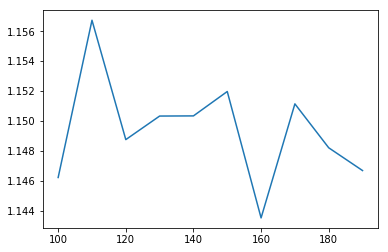

In [45]:
plt.plot(factor_list, rmse_list)

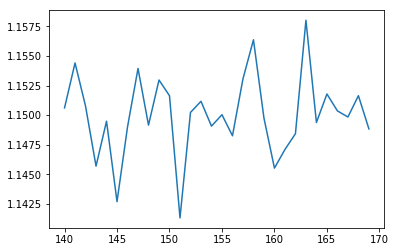

In [47]:
factor_list = np.arange(140, 170, 1)
rmse_list = []
for i in factor_list:
    sgd_result,lossList = MF_SGD_single(data = train, maxIter = i)
    rmse_list.append(rmse_matrix(sgd_result, test_matrix))
plt.plot(factor_list, rmse_list)

In [48]:
min(rmse_list)

1.1413012427359706

In [70]:
lrs = [0.001,0.005,0.01,0.025,0.05,0.1]
lamdas = [0.001,0.005,0.01,0.05,0.1,0.2]
factors = [150, 151, 152]
loss_sgd = {}
for lr in lrs:
    for lm in lamdas:
        for f in factors:
            sgd_result,lossList =  MF_SGD_single(data = train, factors = f, lr=lr, lamda = lm)
            label = (f, lm, lr)
            loss_sgd[label] = rmse_matrix(sgd_result, test_matrix)

In [57]:
from operator import itemgetter

In [243]:
sorted(loss_sgd.items(), key=itemgetter(1))[0]

((150, 0.05, 0.05), 1.1363157902612746)

In [244]:
len(test_matrix[test_matrix.nonzero()])

16192

In [89]:
test_matrix

array([[ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [5]:
new_df = pd.read_csv('new_train.csv')

In [6]:
new_df.drop('Unnamed: 0', axis = 1, inplace=True)

In [7]:
new_df.head()

,categories,price,love thi_x,thi product_x,highli recommend_x,receiv thi_x,thi just_x,great price_x,product just_x,easi use_x,...,year ago_y,use thi product_y,thi item_y,don think_y,like use_y,rank,userID,itemID,rating,binned_price
0,0,13.95,3,4,2,0,0,2,0,3,...,0,0,1,0,0,3225,0,0,2,2
1,0,13.95,3,4,2,0,0,2,0,3,...,0,0,1,0,0,3225,1,0,5,2
2,0,13.95,3,4,2,0,0,2,0,3,...,0,0,1,0,0,3225,2,0,5,2
3,0,13.95,3,4,2,0,0,2,0,3,...,0,0,1,0,0,3225,3,0,5,2
4,0,13.95,3,4,2,0,0,2,0,3,...,0,0,1,0,0,3225,4,0,2,2


In [8]:
new_df2 = new_df.groupby('itemID').mean()

In [9]:
new_df2.reset_index(level=0, inplace=True)

In [10]:
new_df2.head()

,itemID,categories,price,love thi_x,thi product_x,highli recommend_x,receiv thi_x,thi just_x,great price_x,product just_x,...,thi stuff_y,year ago_y,use thi product_y,thi item_y,don think_y,like use_y,rank,userID,rating,binned_price
0,0,0.0,13.95,3.0,4.0,2.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3225.0,25.000000,4.313725,2.0
1,1,1.0,4.20,3.0,15.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,54508.0,75.500000,3.680000,1.0
2,2,2.0,9.67,4.0,41.0,5.0,1.0,1.0,1.0,0.0,...,10.0,5.0,13.0,1.0,1.0,0.0,561.0,145.591398,4.010753,1.0
3,3,3.0,18.99,4.0,14.0,3.0,0.0,0.0,0.0,0.0,...,6.0,1.0,4.0,0.0,0.0,1.0,6216.0,216.929825,4.614035,2.0
4,4,4.0,7.85,11.0,23.0,4.0,0.0,0.0,0.0,0.0,...,8.0,0.0,2.0,1.0,0.0,1.0,20927.0,296.077670,4.009709,1.0


In [40]:
df_item_sim = new_df2.drop(['itemID', 'userID', 'rating', 'price'], axis = 1)

In [41]:
df_item_sim.head()

,categories,love thi_x,thi product_x,highli recommend_x,receiv thi_x,thi just_x,great price_x,product just_x,easi use_x,dark circl_x,...,look like_y,don use_y,thi stuff_y,year ago_y,use thi product_y,thi item_y,don think_y,like use_y,rank,binned_price
0,0.0,3.0,4.0,2.0,0.0,0.0,2.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3225.0,2.0
1,1.0,3.0,15.0,1.0,0.0,1.0,1.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,54508.0,1.0
2,2.0,4.0,41.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,...,2.0,1.0,10.0,5.0,13.0,1.0,1.0,0.0,561.0,1.0
3,3.0,4.0,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,6.0,1.0,4.0,0.0,0.0,1.0,6216.0,2.0
4,4.0,11.0,23.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,...,10.0,2.0,8.0,0.0,2.0,1.0,0.0,1.0,20927.0,1.0


In [42]:
len(df_item_sim)

729

In [43]:
train_matrix

array([[ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  5., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [44]:
sim_item_new = cosine_similarity(train_matrix.T)

In [52]:
train_orig_new,test_orig_new = train_test_split(new_df, test_size = 0.25)

In [53]:
#train_dict: {user:{item,rating}}
train_dict_2 = {}
for user in train_orig_new.userID.unique():
    sub_dict = {}
    subset = train_orig_new[train_orig_new['userID'] == user]
    for item in subset.itemID:
        sub_dict[item] = list(subset[subset['itemID']==item].rating)[0]
    train_dict_2[user] = sub_dict

#test_dict: {(user,item):rating}   
test_dict_2 = {}
for i in range(test_orig_new.shape[0]):
    user = test_orig_new.iloc[i].userID
    item = test_orig_new.iloc[i].itemID
    test_dict_2[user.astype(int),item.astype(int)] = test_orig_new.iloc[i].rating

In [107]:
item_pred = item_based_predict(train, sim_item_new, train_dict_2, test_dict_2, k=5)

In [108]:
RMSE_dict(item_pred,test_dict_2)

1.0701494348468659

In [344]:
two_category = pd.read_csv('two_categories.csv')

In [345]:
two_cat = two_category.drop('asin', axis = 1)

In [346]:
bins = [0, 10, 20, 30, 40, 50, 250]
labels = [1,2,3,4,5,6]
two_cat['binned_price'] = pd.cut(two_cat['price'], bins=bins, labels=labels)

In [330]:
two_cat_2 = two_cat.drop(['price','overall'], axis = 1)

In [319]:
sim_two_cat = cosine_similarity(two_cat_2)

In [320]:
item_pred_two = item_based_predict(train_orig_new, sim_two_cat, train_dict_2, test_dict_2, k=10)

In [321]:
RMSE_dict(item_pred_two,test_dict_2)

1.1148187021406015

In [314]:
#change weight
def factorize_2(df_original,rank_weight,price_weight,cat_weight1,cat_weight2):
    df_minimal = df_original
    
    df_minimal['itemID'] = df_minimal['asin']
    df_minimal = df_minimal.drop('asin',axis = 1)
    
    df_minimal['rating'] = df_minimal['overall'].astype(int)
    df_minimal = df_minimal.drop('overall',axis = 1)
    df_minimal['rank'] = df_minimal['rank'].astype(int)
    df_minimal['rank'] = rank_weight*df_minimal['rank']
    
    
    df_minimal['category1'] = cat_weight1*df_minimal['category1']
    df_minimal['category2'] = cat_weight2*df_minimal['category2']
    
    
    #price go into a few bins
    bins = [0, 10, 20, 30, 40, 50, 250]
    labels = [1,2,3,4,5,6]
    #df_minimal['price'] = 2*df_minimal['price']
    df_minimal['binned_price'] = pd.cut(df_minimal['price'], bins=bins, labels=labels)
    df_minimal['binned_price'] = price_weight*df_minimal['binned_price']
    
    return df_minimal

In [347]:
two_cat.drop('price', axis =1, inplace=True)

In [335]:
from sklearn.tree import DecisionTreeRegressor

In [336]:
#find weight through feature importance
import operator
X = two_cat.copy()
X_target = X.pop('overall')
DT = DecisionTreeRegressor(criterion='mse')
DT.fit(X, X_target)
importance = list(zip(X.columns,DT.feature_importances_))
importance = dict(importance)
importance_s = sorted(importance.items(), key=operator.itemgetter(1),reverse = True)
importance_s

[('thi product', 0.14748918954920726),
 ('love thi', 0.14082253399157879),
 ('highli recommend', 0.10272679176020268),
 ('rank', 0.078287315526500076),
 ('thi just', 0.064442945964609685),
 ('receiv thi', 0.050079459752902011),
 ('category1', 0.047601503702963906),
 ('category2', 0.031923836969223698),
 ('nail polish', 0.031017105415493604),
 ('thi stuff', 0.030938108135198397),
 ('don like', 0.030912004216788715),
 ('look like', 0.028314878584786585),
 ('thi item', 0.027315971706905345),
 ('work great', 0.023755346834129977),
 ('easi use', 0.021932172219931177),
 ('time use', 0.021608591579171554),
 ('use thi product', 0.021225563585832458),
 ('don use', 0.017908890611203248),
 ('product just', 0.014936623383210862),
 ('year ago', 0.013804712890334718),
 ('don think', 0.012852818634161116),
 ('dark circl', 0.010364336348704364),
 ('binned_price', 0.0086288911268429004),
 ('use thi', 0.007527038220338741),
 ('like use', 0.0068531993844468666),
 ('great price', 0.0067301699053313414)]

In [348]:
two_cat_weighted = two_cat.copy()
lst1 = [x[0] for x in importance_s]
lst2 = [x[1] for x in importance_s]
for i in range(len(lst1)):
    two_cat_weighted[lst1[i]] *= lst2[i]

In [350]:
two_cat_weighted.head()

,overall,love thi,thi product,highli recommend,receiv thi,thi just,great price,product just,easi use,dark circl,...,thi stuff,year ago,use thi product,thi item,don think,like use,rank,category1,category2,binned_price
0,4.313725,0.422468,0.589957,0.205454,0.000000,0.000000,0.01346,0.0,0.065797,0.000000,...,0.000000,0.000000,0.000000,0.027316,0.000000,0.000000,252.476593,0.000000,0.000000,0.017258
1,3.680000,0.422468,2.212338,0.102727,0.000000,0.064443,0.00673,0.0,0.000000,0.062186,...,0.000000,0.000000,0.042451,0.000000,0.000000,0.000000,4267.284995,0.047602,0.031924,0.008629
2,4.010753,0.563290,6.047057,0.513634,0.050079,0.064443,0.00673,0.0,0.000000,0.000000,...,0.309381,0.069024,0.275932,0.027316,0.012853,0.000000,43.919184,0.095203,0.063848,0.008629
3,4.614035,0.563290,2.064849,0.308180,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,...,0.185629,0.013805,0.084902,0.000000,0.000000,0.006853,486.633953,0.142805,0.063848,0.017258
4,4.009709,1.549048,3.392251,0.410907,0.000000,0.000000,0.00000,0.0,0.065797,0.000000,...,0.247505,0.000000,0.042451,0.027316,0.000000,0.006853,1638.318652,0.190406,0.095772,0.008629


In [351]:
two_cat_weighted2 = two_cat_weighted.drop('overall', axis = 1)

In [352]:
sim_two_cat2 = cosine_similarity(two_cat_weighted2)
item_pred_weighted = item_based_predict(train_orig_new, sim_two_cat2, train_dict_2, test_dict_2, k=10)
RMSE_dict(item_pred_weighted,test_dict_2)

1.1117107793308418

### Content-based

In [7]:
avg_price = df2['price'].mean()

In [8]:
df2['price'] = df2['price'].fillna(avg_price)

In [9]:
#put description and title together 
df2['words'] = df2['description']+df2['title']

In [10]:
df3 = df2.drop(['description', 'title'], axis = 1)

In [11]:
df3.head()

,asin,salesRank,categories,price,words
0,0205616461,{'Health & Personal Care': 461765},"[[Beauty, Skin Care, Face, Creams & Moisturize...",24.878165,"As we age, our once youthful, healthy skin suc..."
1,0558925278,{'Beauty': 402875},"[[Beauty, Tools & Accessories, Makeup Brushes ...",24.878165,Mineral Powder Brush--Apply powder or mineral ...
2,0733001998,{'Beauty': 540255},"[[Beauty, Skin Care, Body, Moisturizers, Lotio...",24.878165,"From the Greek island of Chios, this Mastiha b..."
3,0737104473,{'Beauty': 931125},"[[Beauty, Makeup, Lips, Lipstick]]",24.878165,Limited edition Hello Kitty Lipstick featuring...
4,0762451459,NaN,"[[Beauty, Tools & Accessories, Mirrors, Makeup...",19.980000,"The mermaid is an elusive (okay, mythical) cre..."


In [12]:
words_summary = df3[['asin','words']]

In [13]:
words_summary.head()

,asin,words
0,0205616461,"As we age, our once youthful, healthy skin suc..."
1,0558925278,Mineral Powder Brush--Apply powder or mineral ...
2,0733001998,"From the Greek island of Chios, this Mastiha b..."
3,0737104473,Limited edition Hello Kitty Lipstick featuring...
4,0762451459,"The mermaid is an elusive (okay, mythical) cre..."


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from nltk.stem.porter import *

In [15]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText
stemmer = PorterStemmer()
def stem_word(text):
    word = text.split(' ')
    word = [stemmer.stem(i) for i in word]
    doc = " ".join(word)
    return doc

In [16]:
words_summary['words'] = words_summary["words"].apply(str)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
words_summary["words"] = words_summary["words"].apply(cleanReviews)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
words_summary["stem"] = words_summary['words'].apply(stem_word)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
reviewText = words_summary["stem"] 
count_Vector = CountVectorizer(ngram_range=(2,4),max_features = 300, stop_words='english') 
textVec =count_Vector.fit_transform(reviewText) 
textVec = DataFrame(textVec.A, columns=count_Vector.get_feature_names())
textVec = textVec.astype(int)

In [20]:
df3['categories'] = df3['categories'].apply(lambda x: x[0])
df3['categories2'] = df3['categories'].apply(lambda x: x[3] if len(x) > 3 else x[0])
df3['categories1'] = df3['categories'].apply(lambda x: x[0])
labels_cat1, levels_cat1 = pd.factorize(df3['categories1'])
labels_cat2, levels_cat2 = pd.factorize(df3['categories2'])
df3['categories1'] = labels_cat1
df3['categories2'] = labels_cat2

In [21]:
df3.head()

,asin,salesRank,categories,price,words,categories2,categories1
0,0205616461,{'Health & Personal Care': 461765},"[Beauty, Skin Care, Face, Creams & Moisturizers]",24.878165,"As we age, our once youthful, healthy skin suc...",0,0
1,0558925278,{'Beauty': 402875},"[Beauty, Tools & Accessories, Makeup Brushes &...",24.878165,Mineral Powder Brush--Apply powder or mineral ...,1,0
2,0733001998,{'Beauty': 540255},"[Beauty, Skin Care, Body, Moisturizers, Lotions]",24.878165,"From the Greek island of Chios, this Mastiha b...",2,0
3,0737104473,{'Beauty': 931125},"[Beauty, Makeup, Lips, Lipstick]",24.878165,Limited edition Hello Kitty Lipstick featuring...,3,0
4,0762451459,NaN,"[Beauty, Tools & Accessories, Mirrors, Makeup ...",19.980000,"The mermaid is an elusive (okay, mythical) cre...",4,0


In [22]:
df3 = df3.dropna(subset=['categories', 'salesRank'], how = 'any')

In [23]:
bins = [0, 10, 20, 30, 40, 50, 250]
labels = [1,2,3,4,5,6]
df3['binned_price'] = pd.cut(df3['price'], bins=bins, labels=labels)

In [24]:
def select_last_element(dic):
    if dic == 0 or dic == {}:
        return 0
    else:
        return list(dic.values())[0]

In [25]:
df3['salesRank'] = df3['salesRank'].apply(lambda x: select_last_element(x))
df4 = df3.drop('categories', axis = 1)

In [26]:
df4.drop(['price', 'words'], axis = 1, inplace=True)

In [21]:
#textvec_asin = words_summary.join(textVec)

In [23]:
#textvec_asin = textvec_asin.drop(['words', 'stem'], axis = 1)

In [27]:
cb_df = df4.join(textVec)

In [28]:
cb_df=cb_df.dropna()

In [29]:
cb_df.shape

(253535, 305)

In [30]:
df_305 = cb_df.set_index('asin')

In [33]:
df_305.head()

,salesRank,categories2,categories1,binned_price,activ ingredi,affect natur,affect natur smell,affect natur smell skin,affect time,affect time fragranc,...,xa instanc mood stress,xa similarli,xa similarli factor,xa similarli factor dri,xa skin,xa skin affect,xa skin affect time,xa xa,xa xa similarli,xa xa similarli factor
asin,,,,,,,,,,,,,,,,,,,,,
0205616461,461765,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0558925278,402875,1,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0733001998,540255,2,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0737104473,931125,3,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1304139212,830938,5,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
array_305 = df_305.values

In [40]:
np.savetxt("content2.csv", array_305, delimiter=",")

In [4]:
content_df = pd.read_csv('content_based_sim.csv')
content_df = content_df.set_index('asin')
content_array = content_df.values

In [ ]:
content_array = df_305.values

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
content_sim = linear_kernel(content_array, content_array)

In [ ]:
content_sim.dump("content_sim.dat")

In [ ]:
#merge cb_df atrain_test_splittest_splite rating df to measure performance, then put the rating only into rmse function to test, the content
#_predict function only use the item feature to predict 
train_content,test_content = train_test_split(, test_size = 0.25)

In [ ]:
 #train_dict: {user:{item,rating}}
train_dict = {}
for user in train_content.userID.unique():
    sub_dict = {}
    subset = train[train['userID'] == user]
    for item in subset.itemID:
        sub_dict[item] = list(subset[subset['itemID']==item].rating)[0]
    train_dict[user] = sub_dict

#test_dict: {(user,item):rating}   
test_dict = {}
for i in range(test.shape[0]):
    user = test.iloc[i].userID
    item = test.iloc[i].itemID
    test_dict[user,item] = test.iloc[i].rating

In [ ]:
def content_predict(sim_item, train_dict):
    

In [ ]:
def content_rmse(pred, test_dict):
    d

### ensemble

In [58]:
def MF_SGD_single_dict(data_dict, factors=150, maxIter=10000000, lr=0.01, conv=1e-20, lamda = 0.01):
    latent_mat_user = np.random.rand(n_users, factors) / 3
    latent_mat_item = np.random.rand(n_items, factors) / 3
    loss_list = []
    iteration = 0
    hist_loss = 0
    
    
    while iteration<maxIter:
        loss = 0
        index = np.random.randint(len(data_dict.keys()))
        #uid, iid, rate = data.iloc[index]
        uid = list(data_dict.keys())[index]
        item_idx = np.random.randint(len(data_dict[uid].keys()))
        iid = list(data_dict[uid].keys())[item_idx]
        rate = data_dict[uid][iid]
        error = rate - np.dot(latent_mat_user[uid], latent_mat_item[iid])
        loss += error**2 + lamda*(np.linalg.norm(latent_mat_user[uid])+np.linalg.norm(latent_mat_item[iid]))
        old_user = latent_mat_user[uid]
        old_item = latent_mat_item[iid]
        latent_mat_user[uid] += lr*(error*latent_mat_item[iid]-lamda*old_user)
        latent_mat_item[iid] += lr*(error*latent_mat_user[uid]-lamda*old_item)
        iteration+=1
        loss_list.append(loss)
        diff = hist_loss-loss
        #to converge
        if abs(hist_loss) > abs(loss):
            lr *= 1.05
        else:
            lr *= 0.5
        if abs(diff) < abs(conv):
            break
        hist_loss = loss
    return np.dot(latent_mat_user, latent_mat_item.T),loss_list

In [62]:
sgd_dict_result, loss_dict_result = MF_SGD_single_dict(train_dict)

In [63]:
rmse_matrix(sgd_dict_result, test_matrix)

1.1531084936188318

In [ ]:
#cross_validation to get rmse for differnet models: item_based, user_based, mf_single_dict
cv_number = 10
rmse_user_based = 0
for i in range(cv_number):
    train_orig,test_orig = train_test_split(df_temp1, test_size = 0.25)
    train,label_level_u_train,label_level_i_train = minimal_and_factorize(train_orig)
    test,label_level_u_test,label_level_i_test = minimal_and_factorize(test_orig)
    
    train_dict = {}
    for user in train.userID.unique():
        sub_dict = {}
        subset = train[train['userID'] == user]
        for item in subset.itemID:
            sub_dict[item] = list(subset[subset['itemID']==item].rating)[0]
        train_dict[user] = sub_dict
 
    test_dict = {}
    for i in range(test.shape[0]):
        user = test.iloc[i].userID
        item = test.iloc[i].itemID
        test_dict[user,item] = test.iloc[i].rating
    #user_based_predict(train,sim_user,test_dict,train_dict,k=5)
    predict_dict = user_based_predict(train, sim_user, test_dict, train_dict, k=3)
    rmse_user_based += RMSE_dict(predict_dict,test_dict)
print(rmse_user_based/cv_number)

In [70]:
df_temp1.shape

(64766, 6)

In [69]:
new_df.shape

(64766, 51)

In [109]:
def cv_model(cv_number = 5, data = df_temp1):
    rmse_user_based = 0
    rmse_item_based = 0
    rmse_mf_single = 0
    for i in range(cv_number):
        train_orig,test_orig = train_test_split(data, test_size = 0.25)
        train,label_level_u_train,label_level_i_train = minimal_and_factorize(train_orig)
        test,label_level_u_test,label_level_i_test = minimal_and_factorize(test_orig)

        train_dict = {}
        for user in train.userID.unique():
            sub_dict = {}
            subset = train[train['userID'] == user]
            for item in subset.itemID:
                sub_dict[item] = list(subset[subset['itemID']==item].rating)[0]
            train_dict[user] = sub_dict

        test_dict = {}
        for i in range(test.shape[0]):
            user_ = test.iloc[i].userID
            item_ = test.iloc[i].itemID
            test_dict[user_,item_] = test.iloc[i].rating
        
        test_matrix = test.pivot(index='userID', columns='itemID', values='rating')
        test_matrix = np.array(test_matrix.fillna(0))
        train_matrix = train.pivot(index='userID', columns='itemID', values='rating')
        train_matrix = np.array(train_matrix.fillna(0))
        
        sim_user = cosine_similarity(train_matrix)
        sim_item_new = cosine_similarity(train_matrix.T)
     
        predict_dict_user = user_based_predict(train, sim_user, test_dict, train_dict, k=3)
        rmse_user_based += RMSE_dict(predict_dict_user,test_dict)
        predict_dict_item = item_based_predict(train, sim_item_new,test_dict, train_dict, k=3)
        rmse_item_based += RMSE_dict(predict_dict_item,test_dict)
        sgd_result,lossList = MF_SGD_single(train, factors = 151)
        rmse_mf_single += rmse_matrix(sgd_result, test_matrix)
        
    print("RMSE for user based CF is %f | RMSE for item based CF is %f | RMSE for matrix factorization is %f"%(rmse_user_based/cv_number, rmse_item_based/cv_number, rmse_mf_single/cv_number))

In [116]:
cv_model(cv_number=3)

/Users/cyian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0 {0: 3, 723: 5, 632: 4, 519: 4, 418: 5, 133: 3, 385: 3, 549: 3, 68: 4, 182: 3}
1 {1: 1, 36: 3, 195: 4, 315: 2, 306: 4, 350: 3, 17: 5, 308: 5, 601: 5, 94: 4, 357: 3}
2 {2: 5, 143: 4, 414: 5, 389: 5, 359: 3, 336: 5, 49: 5, 47: 5, 31: 4, 202: 5, 445: 5, 296: 5, 690: 4, 165: 5, 170: 5, 164: 5, 225: 5, 135: 5, 339: 5, 650: 5, 263: 5, 281: 5, 20: 5, 201: 4}
3 {3: 4, 181: 1}
4 {4: 5, 240: 5, 117: 4, 652: 5, 305: 5, 604: 4, 200: 5, 161: 3}
5 {5: 5, 685: 5, 471: 2}
6 {6: 5}
7 {7: 5, 195: 5, 5: 4, 357: 5, 241: 5, 298: 5, 524: 4}
8 {8: 5, 396: 5, 163: 5, 718: 5, 655: 4, 442: 5, 648: 5}
9 {9: 5}
10 {10: 5, 339: 4, 690: 4, 301: 5, 216: 5, 251: 3, 89: 4, 482: 5}
11 {11: 4, 277: 5, 297: 5, 676: 3, 453: 5, 728: 5, 237: 5, 448: 5, 447: 5, 421: 4, 49: 5}
12 {12: 5, 637: 5}
13 {13: 5, 115: 3}
14 {14: 5, 5: 3}
15 {15: 5, 304: 5, 256: 5, 327: 4, 662: 4, 478: 5, 507: 5, 585: 5, 594: 5, 502: 5, 47: 3, 296: 4, 678: 4, 164: 5, 178: 4, 353: 5, 62: 1, 523: 4, 110: 2, 337: 4, 600: 5, 481: 4, 673: 3, 624: 5, 359:

326 {74: 5, 85: 2, 514: 5}
327 {14: 5}
328 {248: 1, 380: 3, 719: 4, 320: 2}
329 {249: 5, 392: 4, 22: 5, 277: 5, 671: 5}
330 {250: 5, 33: 2}
331 {251: 5, 51: 5, 48: 5, 30: 5, 164: 5, 62: 3, 151: 5, 34: 5, 143: 5, 10: 5, 608: 5, 636: 5, 711: 5, 372: 5, 481: 5, 71: 1, 311: 5, 466: 5, 690: 5, 433: 5, 592: 5, 624: 5, 165: 5, 430: 5, 194: 5, 11: 5, 192: 5, 337: 5, 395: 5, 178: 5, 421: 5, 515: 5, 588: 5, 616: 5, 304: 5, 288: 5, 444: 5, 49: 5, 263: 5, 528: 5, 40: 1, 225: 5, 445: 5, 502: 5, 80: 5, 649: 5, 600: 5}
332 {252: 5, 452: 5, 3: 5, 524: 4, 425: 5, 371: 5}
333 {253: 4, 18: 4, 1: 4}
334 {254: 5, 540: 5, 657: 5, 520: 5}
335 {255: 5, 502: 5, 528: 4, 553: 4, 656: 4, 728: 5}
336 {113: 4, 71: 2, 608: 2, 539: 3, 678: 5, 317: 5, 428: 3, 550: 4, 251: 3, 395: 4, 728: 3, 172: 4, 62: 2, 603: 3}
337 {51: 5, 286: 5, 690: 4, 600: 4, 164: 5, 666: 4, 257: 4, 108: 4, 331: 4, 461: 5, 368: 5, 231: 4, 56: 4, 10: 4, 404: 5, 235: 5, 523: 3, 202: 4, 705: 4, 683: 4, 70: 5, 481: 4, 26: 4, 436: 5, 478: 4, 566: 4, 

937 {139: 5, 362: 1, 249: 4}
938 {212: 4, 93: 3, 53: 5}
939 {81: 5}
940 {73: 5, 190: 5, 155: 5}
941 {504: 5, 576: 5}
942 {103: 4, 376: 5}
943 {217: 5, 600: 3, 80: 4, 599: 4, 502: 4, 76: 4, 666: 2, 135: 4, 336: 4, 478: 3, 49: 5, 34: 2, 108: 4, 673: 2, 573: 3, 618: 3, 633: 4, 646: 5, 65: 5, 348: 4, 565: 3, 414: 3, 503: 5, 352: 3, 433: 4, 566: 3, 347: 4, 31: 1, 27: 3, 82: 3, 389: 3, 164: 3, 595: 3, 56: 3, 727: 4, 564: 2, 528: 5, 143: 3, 672: 4, 281: 3, 391: 5, 151: 4}
944 {21: 5, 254: 5, 273: 5, 520: 5, 109: 5, 312: 5}
945 {18: 4, 94: 3, 454: 5, 130: 5}
946 {506: 4, 127: 1, 62: 1, 239: 5, 408: 1}
947 {507: 4, 662: 5, 416: 5, 235: 4, 70: 5, 523: 5, 223: 4, 674: 4, 597: 4, 65: 4, 19: 4, 678: 3, 709: 4, 587: 4, 446: 3, 388: 2, 34: 5, 269: 5, 353: 4, 391: 3, 66: 4, 64: 4, 76: 4, 519: 4, 632: 5, 93: 3, 80: 2, 667: 4, 629: 3, 433: 4, 304: 4, 68: 5}
948 {508: 5, 41: 5, 139: 5}
949 {307: 4, 705: 4, 516: 3, 156: 4, 231: 2, 206: 4, 662: 4}
950 {509: 5}
951 {498: 5, 418: 3, 566: 4, 4: 5, 56: 3, 535:

1765 {666: 4, 164: 5, 406: 4, 238: 5, 27: 4, 507: 4}
1766 {17: 4}
1767 {342: 5, 410: 5, 154: 5, 542: 5, 280: 4, 543: 5, 59: 5}
1768 {154: 4}
1769 {175: 5, 87: 3, 8: 5, 493: 5, 316: 5, 335: 4, 9: 5}
1770 {286: 5, 339: 4, 156: 4, 638: 5, 507: 5, 593: 4, 305: 5}
1771 {667: 2, 268: 3, 266: 5, 37: 4, 153: 4}
1772 {33: 5, 316: 5, 443: 5, 677: 5, 69: 5, 602: 5, 186: 5}
1773 {635: 4, 605: 5, 101: 3, 539: 5, 137: 4, 135: 3}
1774 {454: 5}
1775 {581: 5, 275: 4, 258: 4, 475: 4, 247: 5, 51: 4, 437: 5, 446: 5, 223: 5}
1776 {35: 4}
1777 {668: 2, 145: 4, 58: 5, 14: 4, 248: 5, 409: 5}
1778 {471: 5, 220: 5, 13: 5, 14: 1, 558: 2}
1779 {175: 5}
1780 {384: 2, 87: 5}
1781 {342: 1, 592: 5, 550: 1, 111: 1, 638: 5}
1782 {579: 5, 262: 4, 146: 5, 700: 5, 87: 5}
1783 {197: 5, 365: 5, 390: 5, 87: 5}
1784 {626: 5, 98: 5, 94: 5, 712: 4}
1785 {594: 4, 207: 5, 573: 3, 80: 3, 353: 5, 20: 5, 337: 5, 330: 5, 217: 5, 296: 5, 359: 4, 325: 5, 70: 5, 551: 5, 47: 4}
1786 {168: 2, 276: 5}
1787 {452: 5, 78: 5, 367: 5}
1788 {333

2519 {240: 1, 441: 2}
2520 {275: 4, 580: 4, 652: 5, 637: 4, 544: 4, 150: 3, 295: 3, 670: 4, 591: 4, 615: 4, 426: 4, 595: 4, 553: 1, 684: 4, 251: 4, 437: 4}
2521 {96: 4, 249: 4}
2522 {216: 4, 592: 5, 569: 4, 656: 4}
2523 {212: 5, 76: 4, 47: 1, 319: 5, 169: 5, 70: 4, 605: 4, 140: 5, 296: 4, 381: 3, 6: 4, 339: 5, 697: 2, 146: 4, 595: 3, 505: 4, 597: 2, 636: 2, 430: 5, 439: 5, 27: 4, 573: 4, 97: 1, 705: 4, 34: 4, 10: 2}
2524 {110: 5, 624: 4, 516: 5, 424: 2, 649: 3, 555: 4, 215: 5, 539: 4, 605: 5, 588: 4, 323: 4, 225: 4, 430: 5, 348: 5}
2525 {229: 4, 33: 4}
2526 {406: 4, 50: 5, 619: 2, 569: 5, 131: 2, 478: 2, 158: 4, 523: 3, 666: 4}
2527 {284: 5, 588: 5, 247: 4, 301: 5, 62: 4, 193: 5}
2528 {426: 4, 576: 5}
2529 {600: 4, 27: 5, 49: 3, 68: 4, 334: 4, 143: 4, 42: 5, 446: 4, 344: 5, 165: 3, 361: 5, 31: 3, 638: 4, 575: 5, 704: 3, 336: 4, 304: 5, 212: 4}
2530 {94: 4, 234: 5, 58: 5, 18: 4}
2531 {581: 5, 226: 4, 606: 5, 327: 5, 112: 4, 368: 1, 266: 5, 174: 5, 551: 5, 428: 2, 597: 3, 172: 4, 339: 3,

3232 {72: 5, 514: 4}
3233 {366: 5, 270: 5, 312: 5, 77: 5, 21: 5, 173: 5, 123: 5, 294: 5, 109: 5, 16: 5}
3234 {169: 5}
3235 {354: 4, 597: 4, 266: 5, 591: 4, 408: 1, 217: 5, 35: 5, 501: 4, 24: 4, 40: 5, 505: 4, 75: 4, 127: 5, 168: 1}
3236 {430: 3, 131: 3, 649: 4, 323: 4, 99: 3, 468: 4, 588: 4}
3237 {245: 5, 187: 5}
3238 {499: 1, 392: 4, 542: 5}
3239 {327: 4, 263: 5, 592: 4, 70: 5, 595: 2, 156: 5, 135: 5, 165: 5, 257: 5, 305: 3, 150: 3, 24: 3}
3240 {74: 5, 392: 5, 1: 5, 438: 5, 688: 5, 287: 5}
3241 {94: 4, 298: 5, 58: 5, 43: 5}
3242 {141: 4}
3243 {687: 5}
3244 {487: 5, 725: 5, 693: 5, 148: 4}
3245 {240: 5, 598: 5, 118: 5, 408: 4, 134: 5}
3246 {67: 5}
3247 {402: 5, 697: 4}
3248 {486: 4, 711: 4, 635: 5}
3249 {39: 5, 98: 5, 517: 5, 467: 1}
3250 {88: 5, 270: 5}
3251 {489: 5, 454: 5}
3252 {718: 5, 316: 5}
3253 {9: 5, 693: 1, 573: 5}
3254 {648: 4}
3255 {701: 2, 399: 4, 138: 4, 112: 4}
3256 {302: 3, 483: 5, 127: 1, 701: 2, 319: 5, 431: 5}
3257 {188: 4}
3258 {302: 5, 458: 5}
3259 {455: 5, 692: 5,

4017 {689: 5, 72: 1}
4018 {683: 5, 556: 5, 501: 2, 418: 5, 406: 4, 566: 5, 274: 5, 618: 4}
4019 {169: 3, 154: 4, 291: 5, 319: 5}
4020 {96: 5}
4021 {64: 5, 269: 5, 177: 4, 26: 4, 238: 5, 278: 4, 466: 5, 592: 5, 416: 5, 52: 4, 128: 4}
4022 {138: 4, 155: 1, 167: 3}
4023 {316: 4, 662: 4, 696: 4, 673: 4}
4024 {534: 5, 531: 5}
4025 {470: 5}
4026 {432: 5}
4027 {212: 5, 608: 4, 600: 5, 271: 5, 405: 5, 143: 5, 555: 5, 194: 5, 216: 5, 156: 4, 121: 2}
4028 {244: 2, 228: 5, 5: 4}
4029 {531: 4, 376: 3}
4030 {81: 4}
4031 {42: 3}
4032 {18: 4, 558: 4}
4033 {168: 4, 622: 3, 396: 3}
4034 {634: 5, 143: 2, 256: 4, 216: 3, 464: 5, 684: 3, 82: 1, 31: 4, 62: 1, 354: 1, 110: 3, 131: 5}
4035 {321: 5, 175: 5}
4036 {29: 5}
4037 {222: 3, 542: 5, 114: 5, 547: 5}
4038 {87: 4, 357: 2, 3: 5, 5: 5, 253: 4}
4039 {609: 4, 681: 5, 542: 5, 252: 5}
4040 {32: 4, 555: 3, 646: 4, 128: 3, 297: 3, 201: 4, 256: 4, 650: 3, 703: 3, 389: 4, 135: 4, 137: 4, 587: 4}
4041 {715: 5}
4042 {350: 5, 688: 4, 220: 5}
4043 {309: 5, 94: 5, 654

4763 {244: 4, 626: 3}
4764 {240: 4}
4765 {351: 5, 362: 5}
4766 {17: 4, 122: 4, 125: 5}
4767 {437: 4, 25: 4, 606: 4, 564: 5, 40: 5}
4768 {71: 4, 683: 4}
4769 {314: 5, 7: 5}
4770 {495: 5}
4771 {643: 5, 18: 5, 280: 4, 409: 5, 363: 5}
4772 {619: 5, 231: 5, 405: 5, 447: 5, 156: 5}
4773 {511: 4, 18: 4}
4774 {41: 5, 547: 5}
4775 {643: 3, 147: 2}
4776 {393: 5, 558: 5, 306: 5}
4777 {539: 4, 549: 3, 398: 5, 162: 3, 143: 4, 624: 3, 607: 2, 555: 4, 566: 5, 137: 5, 574: 5, 225: 4, 405: 4}
4778 {468: 5}
4779 {7: 5, 18: 5}
4780 {69: 5, 365: 5}
4781 {576: 5, 152: 4}
4782 {319: 5}
4783 {395: 4, 57: 4, 444: 5}
4784 {442: 5, 32: 4}
4785 {360: 5, 342: 3}
4786 {496: 4, 570: 5}
4787 {330: 5, 55: 5, 170: 5, 339: 5, 475: 5, 650: 5, 340: 5, 498: 5, 90: 5, 629: 5, 359: 5, 577: 5, 519: 5, 345: 5, 207: 5, 344: 5, 47: 5, 199: 5, 464: 5, 51: 3, 20: 5, 311: 5, 603: 5, 269: 5, 296: 5, 374: 5, 131: 5}
4788 {319: 5, 106: 5, 617: 5}
4789 {95: 4, 418: 3, 70: 4}
4790 {84: 4, 188: 4}
4791 {432: 4}
4792 {280: 5}
4793 {590: 

5464 {214: 5, 342: 5}
5465 {17: 5}
5466 {1: 5}
5467 {147: 5, 28: 5, 722: 5}
5468 {683: 5, 415: 5, 58: 5}
5469 {546: 5, 627: 5}
5470 {290: 5, 381: 5}
5471 {27: 4, 51: 4, 475: 5, 502: 4}
5472 {710: 5}
5473 {137: 4, 27: 2, 143: 4, 201: 3, 624: 5, 602: 2, 539: 5, 411: 5, 605: 3, 135: 5}
5474 {102: 3, 488: 4, 126: 4}
5475 {454: 5, 630: 5}
5476 {290: 5}
5477 {714: 5, 543: 5}
5478 {116: 3, 426: 3, 429: 5, 614: 5}
5479 {42: 5, 484: 5}
5480 {244: 5, 134: 5, 39: 5}
5481 {266: 4, 24: 5, 131: 4, 212: 4, 311: 4, 89: 4, 374: 3}
5482 {530: 5, 213: 5, 184: 4, 468: 4, 157: 1, 677: 5}
5483 {191: 4, 598: 5, 647: 2}
5484 {577: 4, 414: 3, 388: 3, 281: 2}
5485 {319: 5, 277: 5, 120: 5, 132: 4}
5486 {58: 5, 176: 5, 94: 4}
5487 {3: 1}
5488 {651: 4, 697: 5, 166: 5}
5489 {489: 4, 33: 4, 36: 4, 413: 4}
5490 {37: 5, 430: 5}
5491 {151: 4, 673: 4, 478: 4, 639: 4, 263: 4}
5492 {362: 5}
5493 {181: 5, 609: 4, 187: 5}
5494 {489: 5, 509: 5}
5495 {663: 4, 675: 5}
5496 {300: 5}
5497 {492: 5, 17: 5, 561: 5, 509: 5}
5498 {36

6218 {457: 5}
6219 {58: 5, 191: 3, 5: 5}
6220 {472: 5}
6221 {123: 4, 687: 4, 77: 5, 21: 4, 173: 5, 270: 5, 254: 4, 294: 4}
6222 {495: 5, 58: 5, 191: 5, 698: 5, 499: 1}
6223 {72: 4}
6224 {166: 3, 168: 5, 181: 4}
6225 {1: 3}
6226 {468: 3}
6227 {538: 5, 712: 5, 631: 5, 420: 5}
6228 {539: 5, 624: 5, 659: 5, 323: 2, 225: 3, 577: 5, 143: 5, 605: 4, 156: 5, 155: 5}
6229 {134: 5, 635: 5, 531: 5}
6230 {315: 5}
6231 {488: 5, 196: 4, 487: 5}
6232 {69: 5}
6233 {435: 5}
6234 {27: 4, 369: 1, 388: 3, 124: 5, 57: 3, 110: 3, 600: 4, 650: 4, 703: 3, 410: 4, 305: 4, 251: 4}
6235 {472: 5, 94: 4, 364: 4}
6236 {726: 2, 6: 5}
6237 {702: 5}
6238 {470: 5, 106: 3, 706: 5, 78: 4}
6239 {36: 5, 536: 5}
6240 {240: 4}
6241 {314: 5}
6242 {248: 5, 510: 5, 195: 5, 241: 5}
6243 {531: 5, 36: 5, 454: 2}
6244 {384: 5, 531: 5, 5: 5, 103: 4, 39: 1}
6245 {417: 4, 86: 4, 323: 4, 632: 5, 447: 5, 137: 4, 192: 4, 237: 4, 256: 5}
6246 {452: 5, 232: 5, 41: 5}
6247 {48: 2, 246: 4, 717: 5, 334: 5, 0: 5}
6248 {209: 4, 169: 5, 454: 4}


6993 {116: 5}
6994 {205: 5, 675: 5}
6995 {303: 5, 127: 5}
6996 {413: 4, 303: 4}
6997 {12: 5, 24: 5, 82: 5, 212: 5, 574: 5}
6998 {244: 5, 14: 5, 531: 5, 511: 4, 94: 5, 626: 5}
6999 {134: 5}
7000 {491: 2, 252: 4}
7001 {181: 3}
7002 {291: 5, 693: 5}
7003 {332: 4}
7004 {492: 3, 586: 4, 6: 3}
7005 {174: 3}
7006 {20: 5, 263: 5, 296: 5, 359: 5, 650: 5, 336: 3, 334: 5, 49: 5, 331: 5}
7007 {315: 5, 61: 5, 393: 5}
7008 {726: 5, 9: 5}
7009 {538: 5, 287: 4}
7010 {676: 2, 465: 5}
7011 {301: 4}
7012 {23: 4, 238: 4, 535: 4}
7013 {351: 5, 292: 5, 485: 4}
7014 {8: 5, 346: 5, 42: 5}
7015 {61: 4, 484: 5, 718: 5}
7016 {174: 4}
7017 {261: 5, 169: 4, 671: 5}
7018 {580: 4, 3: 4}
7019 {87: 5}
7020 {315: 5, 187: 5, 514: 5, 493: 5}
7021 {449: 3, 312: 5, 173: 4, 88: 5, 294: 5}
7022 {710: 5, 378: 2}
7023 {14: 1, 538: 5, 94: 3, 18: 5}
7024 {29: 5}
7025 {655: 5, 390: 5}
7026 {116: 5}
7027 {85: 5, 260: 5, 222: 5, 440: 4, 244: 5}
7028 {174: 4, 6: 3}
7029 {87: 5}
7030 {154: 5, 512: 3}
7031 {441: 5, 335: 4}
7032 {495: 

7765 {72: 5, 689: 5}
7766 {361: 3, 620: 3, 68: 4}
7767 {638: 5, 112: 5}
7768 {470: 5, 452: 5, 222: 4}
7769 {153: 5, 156: 5, 279: 5, 567: 4, 194: 5, 630: 5, 48: 4, 604: 4, 86: 3}
7770 {280: 5, 276: 5}
7771 {241: 3, 7: 4, 220: 4, 244: 4}
7772 {97: 5, 126: 5}
7773 {105: 3, 38: 5, 22: 5, 46: 1, 132: 3, 279: 5}
7774 {116: 5, 342: 5}
7775 {655: 5, 390: 4}
7776 {382: 5, 183: 5}
7777 {631: 5}
7778 {335: 5, 644: 4}
7779 {425: 5}
7780 {717: 4, 247: 4, 112: 5, 666: 5, 478: 4, 284: 4, 281: 4, 2: 4, 62: 4, 162: 3}
7781 {12: 5, 251: 4}
7782 {72: 5, 452: 5, 376: 3, 147: 5, 8: 5, 159: 5}
7783 {113: 4, 433: 3, 423: 2}
7784 {3: 4}
7785 {318: 5, 342: 5, 335: 4}
7786 {262: 5, 134: 5, 612: 3, 669: 2}
7787 {230: 5}
7788 {159: 5, 671: 5, 130: 5}
7789 {14: 5}
7790 {6: 5, 213: 5}
7791 {434: 4, 705: 4}
7792 {74: 5, 688: 5, 1: 4, 287: 5, 106: 5, 407: 5, 392: 5, 115: 5}
7793 {116: 5}
7794 {56: 2, 474: 5}
7795 {401: 3, 293: 5}
7796 {128: 5, 426: 4, 437: 4, 599: 5, 19: 5, 113: 4}
7797 {187: 4, 319: 5, 146: 5}
7798 

8466 {691: 5}
8467 {413: 5}
8468 {7: 5, 58: 5}
8469 {14: 3, 626: 5}
8470 {392: 5, 252: 5}
8471 {67: 3, 169: 4, 714: 5, 671: 4}
8472 {439: 5, 293: 5, 157: 5}
8473 {472: 3, 721: 5}
8474 {127: 5, 319: 5, 676: 4}
8475 {33: 5, 319: 4}
8476 {387: 5, 162: 5}
8477 {262: 5, 239: 5, 283: 5}
8478 {280: 4}
8479 {684: 5, 601: 4}
8480 {151: 5, 150: 4, 519: 4, 93: 4, 99: 3, 24: 4, 10: 3}
8481 {272: 5}
8482 {376: 5}
8483 {27: 4, 91: 4, 193: 4, 567: 4, 684: 4}
8484 {191: 5}
8485 {625: 3, 472: 3}
8486 {397: 2, 378: 5, 663: 5}
8487 {647: 5, 439: 5}
8488 {680: 5}
8489 {658: 3, 320: 3}
8490 {534: 5, 538: 5, 7: 5, 98: 5, 103: 5}
8491 {41: 5, 198: 5}
8492 {366: 5, 129: 5, 349: 5, 123: 4, 270: 5}
8493 {381: 4}
8494 {205: 3, 425: 2, 376: 4, 147: 4}
8495 {566: 5, 99: 5, 231: 4, 151: 5, 477: 5, 275: 5}
8496 {672: 5}
8497 {402: 5, 87: 5}
8498 {123: 5, 270: 5}
8499 {291: 5, 261: 5}
8500 {401: 5}
8501 {18: 4, 103: 5, 377: 5, 58: 5}
8502 {597: 3, 642: 4}
8503 {264: 2, 118: 5}
8504 {496: 3, 719: 2}
8505 {655: 3}
8506

9222 {82: 5, 278: 4, 444: 5, 27: 5, 684: 2}
9223 {159: 5, 267: 5, 439: 5, 78: 5, 97: 5}
9224 {355: 5}
9225 {476: 5, 276: 5}
9226 {668: 1, 234: 5, 264: 5}
9227 {469: 4, 586: 2}
9228 {579: 2, 106: 5}
9229 {276: 3}
9230 {49: 5, 574: 5, 158: 5, 629: 5, 304: 5}
9231 {152: 5, 382: 5}
9232 {658: 5, 442: 3}
9233 {147: 5, 69: 4, 702: 5}
9234 {564: 2, 3: 5}
9235 {489: 4, 36: 5}
9236 {408: 5}
9237 {334: 5, 619: 5, 482: 5, 62: 3}
9238 {123: 4, 16: 4, 270: 4}
9239 {516: 3, 475: 5}
9240 {320: 3, 460: 5}
9241 {392: 5}
9242 {589: 4, 5: 4}
9243 {452: 4}
9244 {725: 3, 9: 5, 41: 5, 299: 4}
9245 {276: 4}
9246 {8: 5}
9247 {511: 4, 94: 3}
9248 {29: 5}
9249 {18: 5, 5: 5}
9250 {318: 3, 443: 5}
9251 {127: 5}
9252 {230: 4, 103: 5}
9253 {85: 5}
9254 {141: 5, 458: 5}
9255 {615: 5, 194: 5, 473: 5, 369: 4}
9256 {313: 5}
9257 {375: 5, 402: 2, 87: 5}
9258 {543: 5, 280: 1, 493: 5}
9259 {183: 5, 62: 5, 336: 3}
9260 {169: 5, 87: 5, 120: 5}
9261 {614: 5, 28: 3, 550: 1}
9262 {404: 4}
9263 {580: 4, 301: 4, 27: 4}
9264 {36:

10007 {399: 5, 530: 5}
10008 {245: 5}
10009 {444: 5, 666: 3, 31: 2}
10010 {488: 5}
10011 {397: 5, 378: 4}
10012 {145: 3, 510: 5, 357: 5, 253: 5, 7: 5, 376: 5}
10013 {132: 5, 488: 5}
10014 {285: 4, 40: 2, 174: 3, 507: 5, 238: 5}
10015 {454: 5}
10016 {342: 5, 5: 5}
10017 {208: 5, 675: 5}
10018 {93: 2, 158: 5, 337: 5, 599: 5}
10019 {632: 5, 256: 4, 165: 5}
10020 {8: 3, 671: 1}
10021 {126: 5, 3: 5}
10022 {537: 2, 554: 5}
10023 {392: 5, 222: 5}
10024 {14: 5, 287: 5}
10025 {628: 5}
10026 {524: 5, 680: 1}
10027 {342: 4, 392: 5}
10028 {493: 3}
10029 {432: 5, 215: 5}
10030 {680: 2, 413: 5}
10031 {363: 5, 531: 5, 39: 5, 18: 5}
10032 {415: 5, 63: 4}
10033 {342: 5}
10034 {456: 3}
10035 {413: 5, 35: 5, 36: 5, 489: 5}
10036 {439: 5, 142: 4}
10037 {190: 5, 290: 5, 676: 5}
10038 {619: 5, 678: 5}
10039 {303: 5}
10040 {376: 5, 689: 5}
10041 {522: 3, 165: 5, 63: 5}
10042 {724: 5, 476: 1}
10043 {661: 4, 341: 4}
10044 {651: 2, 214: 5}
10045 {125: 4, 238: 4}
10046 {244: 4, 94: 3, 103: 1}
10047 {272: 3, 72: 

10768 {570: 5}
10769 {236: 3, 319: 5, 169: 5, 134: 5}
10770 {626: 5}
10771 {58: 5, 276: 1}
10772 {681: 1}
10773 {546: 5, 465: 4, 393: 4}
10774 {309: 5}
10775 {596: 4}
10776 {390: 5, 63: 5}
10777 {224: 5, 488: 4}
10778 {76: 4, 331: 4}
10779 {267: 5}
10780 {234: 5}
10781 {715: 4, 648: 5}
10782 {341: 5, 695: 3}
10783 {618: 3, 164: 4, 664: 4}
10784 {38: 3, 41: 3}
10785 {120: 5, 319: 5}
10786 {4: 5}
10787 {377: 5, 531: 5}
10788 {702: 5}
10789 {557: 4}
10790 {596: 5}
10791 {452: 4}
10792 {465: 4, 689: 4, 72: 1}
10793 {103: 1}
10794 {614: 5, 342: 5, 250: 4}
10795 {319: 5, 689: 5, 299: 4}
10796 {218: 4}
10797 {14: 4}
10798 {401: 4}
10799 {422: 5}
10800 {220: 5, 357: 5, 298: 5, 233: 5}
10801 {58: 4, 547: 5}
10802 {122: 5, 13: 5}
10803 {9: 4}
10804 {114: 5, 129: 5, 316: 5}
10805 {222: 2, 665: 5}
10806 {632: 5}
10807 {264: 3, 433: 2}
10808 {173: 5, 88: 5, 349: 5, 21: 5}
10809 {504: 5}
10810 {362: 1}
10811 {244: 4, 679: 4, 130: 5, 36: 4}
10812 {546: 5, 61: 4, 163: 4}
10813 {342: 5, 41: 4}
10814 {6

11503 {69: 5, 219: 3}
11504 {663: 4, 675: 5}
11505 {115: 5}
11506 {9: 2, 715: 5}
11507 {240: 5}
11508 {488: 5}
11509 {293: 5}
11510 {522: 5}
11511 {97: 4, 571: 3}
11512 {94: 3, 244: 3, 511: 3, 377: 5, 58: 4, 18: 3}
11513 {455: 5}
11514 {102: 5}
11515 {12: 2}
11516 {370: 5, 543: 4}
11517 {412: 5}
11518 {78: 5, 367: 4}
11519 {310: 4}
11520 {617: 4, 78: 4}
11521 {22: 5, 134: 5}
11522 {191: 5}
11523 {158: 4, 131: 4}
11524 {537: 3}
11525 {105: 5, 532: 5}
11526 {509: 4}
11527 {454: 5, 640: 5}
11528 {708: 4}
11529 {99: 4, 120: 4}
11530 {384: 3, 169: 5, 681: 5, 328: 3, 160: 4, 179: 4}
11531 {290: 1}
11532 {14: 5, 103: 5, 517: 4, 39: 3}
11533 {363: 4, 94: 2}
11534 {439: 2}
11535 {319: 5, 154: 3}
11536 {327: 5}
11537 {115: 1}
11538 {658: 4, 647: 5}
11539 {134: 5}
11540 {320: 1, 465: 1}
11541 {631: 3}
11542 {454: 5, 370: 5}
11543 {721: 4, 234: 5}
11544 {41: 5}
11545 {89: 4, 65: 3, 381: 4, 257: 5, 433: 3}
11546 {358: 5}
11547 {309: 5}
11548 {9: 5}
11549 {127: 5}
11550 {392: 5, 106: 5, 314: 4}
1155

12208 {468: 2, 127: 4}
12209 {342: 2, 63: 5, 663: 4}
12210 {249: 5, 672: 5, 256: 5}
12211 {337: 4}
12212 {671: 5, 8: 5}
12213 {94: 5}
12214 {219: 5, 522: 5, 675: 5, 404: 5, 227: 5}
12215 {606: 5}
12216 {702: 4, 111: 2, 33: 3}
12217 {483: 4}
12218 {127: 5}
12219 {236: 4, 43: 5}
12220 {155: 5, 231: 4}
12221 {40: 4}
12222 {137: 5}
12223 {224: 5}
12224 {267: 5}
12225 {509: 5}
12226 {234: 5}
12227 {725: 5, 308: 4, 494: 4, 280: 4}
12228 {166: 1, 663: 2}
12229 {531: 3}
12230 {666: 2}
12231 {366: 5, 509: 5, 173: 3}
12232 {222: 5}
12233 {229: 2, 513: 5}
12234 {554: 5, 614: 5, 542: 5, 635: 4}
12235 {310: 2, 429: 1}
12236 {191: 5}
12237 {142: 5}
12238 {681: 5, 147: 5}
12239 {196: 1}
12240 {127: 5}
12241 {3: 5}
12242 {441: 3, 542: 5}
12243 {3: 4}
12244 {401: 5}
12245 {484: 5}
12246 {87: 5}
12247 {240: 3}
12248 {5: 4, 531: 5, 18: 4, 244: 5}
12249 {521: 5, 617: 1, 376: 1}
12250 {349: 5, 449: 5, 184: 5, 242: 5}
12251 {532: 4}
12252 {98: 3}
12253 {699: 5}
12254 {590: 5}
12255 {620: 5}
12256 {696: 4}
1

12925 {114: 5}
12926 {142: 5, 340: 5}
12927 {240: 5, 606: 3, 499: 4}
12928 {188: 5}
12929 {355: 4, 493: 4}
12930 {422: 4, 46: 1}
12931 {125: 5}
12932 {423: 5, 564: 2}
12933 {239: 5, 625: 5}
12934 {439: 5}
12935 {390: 5}
12936 {240: 5}
12937 {79: 5}
12938 {442: 4, 319: 5, 554: 5}
12939 {426: 5}
12940 {376: 5, 154: 5, 322: 4}
12941 {96: 2}
12942 {521: 5}
12943 {236: 5, 228: 5}
12944 {483: 5}
12945 {458: 5}
12946 {704: 5, 340: 5}
12947 {621: 3}
12948 {645: 4, 21: 4, 692: 5}
12949 {67: 1}
12950 {127: 3}
12951 {18: 3, 248: 5}
12952 {335: 4, 342: 5}
12953 {234: 5}
12954 {625: 1, 722: 5}
12955 {350: 5}
12956 {268: 3, 212: 4}
12957 {681: 5, 514: 5}
12958 {36: 5, 617: 4}
12959 {376: 1, 67: 2}
12960 {18: 5}
12961 {288: 1, 217: 3}
12962 {369: 2}
12963 {697: 1}
12964 {308: 5, 59: 5, 160: 5, 324: 5}
12965 {306: 4, 350: 5}
12966 {413: 5}
12967 {722: 5, 213: 3}
12968 {380: 3, 467: 5}
12969 {443: 5, 640: 1}
12970 {622: 4, 689: 4}
12971 {370: 2, 103: 5}
12972 {435: 5, 7: 5}
12973 {244: 5, 58: 5}
12974 

13644 {234: 4, 18: 5}
13645 {290: 5}
13646 {471: 1, 717: 5}
13647 {342: 5, 252: 5}
13648 {280: 5}
13649 {514: 1, 449: 1}
13650 {655: 5}
13651 {240: 5, 87: 5}
13652 {621: 4}
13653 {579: 5}
13654 {224: 5}
13655 {488: 5}
13656 {343: 4, 9: 5}
13657 {272: 3, 43: 5, 1: 5}
13658 {244: 5, 560: 5}
13659 {534: 5}
13660 {426: 5}
13661 {494: 5}
13662 {262: 4, 454: 2}
13663 {671: 5}
13664 {264: 5}
13665 {506: 5}
13666 {375: 2, 230: 5}
13667 {530: 5, 42: 5, 494: 5, 565: 1}
13668 {609: 2, 328: 5}
13669 {365: 5}
13670 {245: 5}
13671 {280: 4, 342: 5, 699: 4}
13672 {358: 5}
13673 {94: 5, 234: 2}
13674 {51: 5}
13675 {96: 5, 570: 5}
13676 {319: 2}
13677 {111: 4, 105: 2, 439: 4, 87: 5}
13678 {92: 2}
13679 {726: 5}
13680 {25: 5, 395: 5, 278: 5}
13681 {712: 5}
13682 {442: 5}
13683 {634: 5}
13684 {401: 1}
13685 {726: 4}
13686 {644: 1}
13687 {175: 5}
13688 {679: 5}
13689 {105: 5}
13690 {220: 3}
13691 {632: 5}
13692 {262: 5}
13693 {315: 1, 462: 5}
13694 {29: 5, 229: 5}
13695 {19: 4}
13696 {266: 3, 713: 4}
13697

14270 {461: 3}
14271 {222: 2, 543: 3, 402: 1}
14272 {249: 5}
14273 {287: 5}
14274 {101: 5}
14275 {459: 3}
14276 {358: 2}
14277 {105: 5}
14278 {5: 5}
14279 {584: 5}
14280 {262: 4}
14281 {316: 5}
14282 {651: 5, 141: 5}
14283 {22: 5}
14284 {570: 5}
14285 {524: 4}
14286 {283: 5}
14287 {263: 3}
14288 {250: 5, 302: 5}
14289 {119: 5}
14290 {228: 4, 134: 5, 350: 5}
14291 {397: 2, 671: 5}
14292 {612: 4}
14293 {480: 5, 439: 5, 120: 4}
14294 {193: 3, 713: 3, 247: 4}
14295 {446: 5}
14296 {220: 5}
14297 {155: 5}
14298 {335: 3}
14299 {336: 5}
14300 {309: 5}
14301 {459: 2}
14302 {609: 5}
14303 {303: 5, 126: 5}
14304 {114: 5}
14305 {176: 5, 236: 5, 253: 4, 134: 4}
14306 {220: 5}
14307 {125: 1}
14308 {175: 5}
14309 {276: 5}
14310 {17: 5}
14311 {504: 5}
14312 {208: 2}
14313 {485: 4}
14314 {159: 5}
14315 {3: 4}
14316 {494: 5}
14317 {673: 5}
14318 {316: 5}
14319 {181: 4}
14320 {598: 4}
14321 {576: 5}
14322 {388: 4}
14323 {291: 5}
14324 {314: 5}
14325 {214: 5}
14326 {610: 3}
14327 {488: 2}
14328 {402: 5, 4

14991 {229: 2}
14992 {33: 1, 272: 4}
14993 {341: 5}
14994 {468: 5}
14995 {7: 5}
14996 {307: 5}
14997 {401: 3}
14998 {517: 4}
14999 {243: 4}
15000 {8: 5}
15001 {439: 5}
15002 {280: 2}
15003 {94: 5}
15004 {506: 1}
15005 {320: 3, 72: 5}
15006 {3: 4}
15007 {3: 4}
15008 {291: 4}
15009 {455: 5}
15010 {468: 5}
15011 {708: 1}
15012 {163: 5}
15013 {176: 5}
15014 {8: 5}
15015 {429: 5}
15016 {580: 4}
15017 {84: 5}
15018 {33: 5}
15019 {371: 5}
15020 {220: 1}
15021 {205: 3}
15022 {601: 5}
15023 {509: 1}
15024 {198: 5}
15025 {484: 5, 367: 2, 69: 5}
15026 {583: 4}
15027 {454: 5}
15028 {3: 5}
15029 {718: 4}
15030 {554: 5}
15031 {290: 5}
15032 {641: 5}
15033 {303: 3}
15034 {319: 5}
15035 {198: 5}
15036 {547: 5, 441: 5}
15037 {392: 5, 289: 5}
15038 {232: 2}
15039 {362: 3}
15040 {84: 5}
15041 {279: 5}
15042 {491: 4}
15043 {668: 5, 393: 1}
15044 {376: 5}
15045 {189: 2}
15046 {17: 1, 122: 3}
15047 {163: 4}
15048 {473: 3}
15049 {722: 5}
15050 {127: 5}
15051 {315: 5}
15052 {658: 5}
15053 {36: 5}
15054 {105: 

AttributeError: 'numpy.int64' object has no attribute 'items'